In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime , timedelta
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('ggplot')
sns.set(style="whitegrid")

plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']=12
plt.rcParams['axes.labelsize']=14
plt.rcParams['axes.titlesize']=16
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

In [ ]:
API_KEY="9d8ad33c3bfde1431f1748da6878dc8c082b017fab31638caa50190fac77ce8a"

JERSEY_CITY_LAT=40.7282
JERSEY_CITY_LON=74.0776

In [ ]:
import requests

# --- IMPORTANT ---
# Replace 'your_actual_api_key' with the real API key you received from OpenAQ.
API_KEY = '9d8ad33c3bfde1431f1748da6878dc8c082b017fab31638caa50190fac77ce8a'

def check_openaq_api_key():
    """
    Makes a minimal request to the OpenAQ API to check if the API key is valid.
    """
    # We use a simple endpoint and limit the result to 1 to be efficient.
    url = "https://api.openaq.org/v3/locations"
    headers = {
        "X-API-Key": API_KEY
    }
    params = {
        "limit": 1
    }

    print("Testing API key...")

    try:
        response = requests.get(url, headers=headers, params=params)

        # Check the HTTP status code from the server's response.
        if response.status_code == 200:
            print("\n✅ Success! Your API key is valid.")
            return True
        elif response.status_code == 401:
            print("\n❌ Failure! Status code 401: Unauthorized.")
            print("   This means your API key is invalid, expired, or missing.")
            return False
        else:
            print(f"\n❌ Failure! Received status code: {response.status_code}")
            print(f"   Response: {response.text}")
            return False

    except requests.exceptions.RequestException as e:
        print(f"\n❌ An error occurred during the network request: {e}")
        print("   This might be a network issue or a problem reaching the OpenAQ server.")
        return False

# --- Run the validation function ---
check_openaq_api_key()


Testing API key...

✅ Success! Your API key is valid.


True

In [ ]:
import requests
import pandas as pd
import json

# --- Your Details ---
# Replace with your actual key
API_KEY = '9d8ad33c3bfde1431f1748da6878dc8c082b017fab31638caa50190fac77ce8a'
JERSEY_CITY_LAT = 40.7178
JERSEY_CITY_LON = -74.0431

def get_locations_debug(radius=25000): # Increased radius to maximum
    base_url = "https://api.openaq.org/v3/locations"
    params = {
        "coordinates": f"{JERSEY_CITY_LAT},{JERSEY_CITY_LON}",
        "radius": radius,
        "limit": 500
    }
    headers = {
        "X-API-KEY": API_KEY
    }

    # --- DEBUG STEP 1: Print the full request URL ---
    # This helps verify the query is structured correctly.
    request_url = requests.Request('GET', base_url, params=params, headers=headers).prepare().url
    print(f"--- Requesting URL: {request_url} ---\n")

    try:
        response = requests.get(base_url, params=params, headers=headers)

        if response.status_code == 200:
            print("--- Successfully retrieved stations (Status 200) ---\n")
            data = response.json()

            # --- DEBUG STEP 2: Print the raw JSON response ---
            # This shows you what the API returned before pandas touches it.
            print("--- Raw API Response: ---")
            print(json.dumps(data, indent=2))
            print("-------------------------\n")

            results = data.get('results', [])

            if not results:
                print("API returned 0 results for the given coordinates and radius.")
                return pd.DataFrame()

            locations_df = pd.json_normalize(results)

            column_mapping = {
                'id': 'location_id',
                'name': 'location_name',
                'coordinates.latitude': 'latitude',
                'coordinates.longitude': 'longitude'
            }

            # Simplified and more robust column handling
            locations_df.rename(columns=column_mapping, inplace=True)

            required_columns = ['location_id', 'location_name', 'latitude', 'longitude', 'country', 'isMobile', 'isMonitor', 'owner', 'provider']

            for col in required_columns:
                if col not in locations_df.columns:
                    locations_df[col] = None # Add missing columns

            print(f"Found {len(locations_df)} monitoring stations.")
            return locations_df[required_columns]

        else:
            print(f"Failed to retrieve stations. Status code: {response.status_code}")
            print(f"Response Body: {response.text}")
            return pd.DataFrame()

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

# --- Run the debugging function ---
locations_data = get_locations_debug()
print("\n--- Final DataFrame Head: ---")
print(locations_data.head())
print("--------------------------")


Streaming output truncated to the last 5000 lines.
          "name": "US Public Domain",
          "attribution": {
            "name": "Unknown Governmental Organization",
            "url": null
          },
          "dateFrom": "2016-01-30",
          "dateTo": null
        }
      ],
      "bounds": [
        -73.995,
        40.7142,
        -73.995,
        40.7142
      ],
      "distance": 4083.83746037,
      "datetimeFirst": {
        "utc": "2016-03-10T08:00:00Z",
        "local": "2016-03-10T03:00:00-05:00"
      },
      "datetimeLast": {
        "utc": "2020-02-19T16:00:00Z",
        "local": "2020-02-19T11:00:00-05:00"
      }
    },
    {
      "id": 664,
      "name": "Bklyn - PS274",
      "locality": "New York-Northern New Jersey-Long Island",
      "timezone": "America/New_York",
      "country": {
        "id": 155,
        "code": "US",
        "name": "United States"
      },
      "owner": {
        "id": 4,
        "name": "Unknown Governmental Organization"
 

In [ ]:
import requests
import pandas as pd
import time
import threading
from IPython.display import display, clear_output

# --- 1. Configuration ---
# IMPORTANT: Replace 'your_actual_api_key' with your valid API key.
API_KEY = 'your_actual_api_key'
JERSEY_CITY_LAT = 40.7178
JERSEY_CITY_LON = -74.0431
SEARCH_RADIUS_METERS = 25000  # Using a larger radius
POLL_INTERVAL_SECONDS = 10 # 10 minutes (10 * 60)


# --- 2. Data Fetching Function ---
def get_locations():
    """Fetches air quality monitoring locations from the OpenAQ API."""
    base_url = "https://api.openaq.org/v3/locations"
    params = {
        "coordinates": f"{JERSEY_CITY_LAT},{JERSEY_CITY_LON}",
        "radius": SEARCH_RADIUS_METERS,
        "limit": 500
    }
    headers = {"X-API-Key": API_KEY}

    try:
        response = requests.get(base_url, params=params, headers=headers)
        if response.status_code == 200:
            data = response.json()
            return pd.json_normalize(data.get('results', []))
        else:
            # Print error but don't stop the loop
            print(f"API Error: Status {response.status_code}, {response.text}")
            return pd.DataFrame()
    except requests.exceptions.RequestException as e:
        print(f"Network Error: {e}")
        return pd.DataFrame()


# --- 3. Background Polling Task ---
# This global flag is used to signal the thread to stop.
stop_polling_thread = False

def start_polling_loop():
    """The main loop that runs in the background to fetch and display data."""
    global stop_polling_thread
    while not stop_polling_thread:
        # Clear the output of the cell to make it look clean
        clear_output(wait=True)

        print(f"Last updated: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print("Fetching new data from OpenAQ...")

        locations_df = get_locations()

        if not locations_df.empty:
            print(f"Successfully retrieved {len(locations_df)} station(s).")
            # Display a clean subset of the DataFrame in the cell's output
            display(locations_df[['id', 'name', 'country', 'city']].head())
        else:
            print("No data was retrieved in this cycle.")

        print(f"\nNext update in {int(POLL_INTERVAL_SECONDS / 60)} minutes...")

        # This responsive sleep checks every second if it should stop.
        for _ in range(POLL_INTERVAL_SECONDS):
            if stop_polling_thread:
                break
            time.sleep(1)

    print("--- Background polling has been stopped. ---")


# --- 4. Start the Background Thread ---
# This ensures you don't start multiple threads by running the cell again.
if 'polling_thread' not in locals() or not polling_thread.is_alive():
    stop_polling_thread = False
    polling_thread = threading.Thread(target=start_polling_loop)
    polling_thread.daemon = True # Allows Colab to exit cleanly
    polling_thread.start()
    print("✅ Background polling started. The output below will update automatically every 10 minutes.")
else:
    print("ℹ️ Polling thread is already running.")



Last updated: 2025-10-27 19:55:52
Fetching new data from OpenAQ...


In [ ]:
import time
import threading
from IPython.display import clear_output

# Global flag to stop this test thread
stop_test_thread = False

def simple_loop_test():
    """A simple loop that only prints and sleeps."""
    global stop_test_thread
    while not stop_test_thread:
        clear_output(wait=True)
        print(f"This output updated at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print("\nThis loop does NOT make an API call.")
        print("It should be very close to a 10-second interval.")
        time.sleep(10)
    print("--- Simple loop test stopped. ---")


# Start the test thread
if 'test_thread' not in locals() or not test_thread.is_alive():
    stop_test_thread = False
    test_thread = threading.Thread(target=simple_loop_test)
    test_thread.daemon = True
    test_thread.start()
    print("✅ Simple loop test started. Watch the timestamp above.")
else:
    print("ℹ️ Test thread is already running.")

# To stop this test, run this in a new cell:
# stop_test_thread = True


This output updated at: 2025-10-27 19:54:59

This loop does NOT make an API call.
It should be very close to a 10-second interval.


In [ ]:
stop_polling_thread = True


In [ ]:
def get_jersey_city_locations(radius=25000):
  base_url=("https://api.openaq.org/v3/locations")
  params={
      "coordinates": f"{JERSEY_CITY_LAT},{JERSEY_CITY_LON}",
      "radius": radius,
      "limit": 500
  }
  headers={
      "X-API-KEY":API_KEY
  }
  try:
    response=requests.get(base_url,params=params,headers=headers)

    if response.status_code==200:
      print("Successfully retrieved stations")
      data=response.json()

      results=data.get('results', [])

      if not results:
        return pd.DataFrame()
      locations_df=pd.json_normalize(results)

      column_mapping={
          'id':'location_id',
          'name':'location_name',
          'coordinates.latitude':'latitude',
          'coordinates.longitude':'longitude',
          'country.code':'country_iso',
          'owner.name':'owner_name',
          'provider.url':'provider'
      }

      for old_col,new_col in column_mapping.items():
        if old_col in locations_df.columns:
          locations_df[new_col]=locations_df[old_col]

      required_columns=['location_id','location_name','latitude','longitude','country_iso','isMobile','isMonitor','owner_name','provider']

      for col in required_columns:
        if col not in locations_df.columns:
          locations_df[col]=None

      print(f"found {len(locations_df)} monitoring stations.")
      return locations_df[required_columns]
    else:
      print(f"Failed to retrieve stations. Status code: {response.status_code}")
      print(response.text)
      return pd.DataFrame()

  except Exception as e:
    print(f"An error occurred: {e}")
    return pd.DataFrame()


In [ ]:
def extract_parameters(location_row):
  parameters=[]
  if 'sensors' in location_row and location_row['sensors']:
    for sensor in location_row['sensors']:
      if 'parameter' in sensor and sensor['parameter']:
         param_name=sensor['parameter'].get('name','unkown')
         parameters.append(param_name)
  return parameters


jersey_city_locations = get_jersey_city_locations()

Successfully retrieved stations


In [ ]:
if not jersey_city_locations.empty:
  print("\nMonitoring Stations Information:")
  location_info=jersey_city_locations[['location_id','location_name','latitude','longitude','country_iso','isMobile','isMonitor']]
  display(location_info.head())

  jersey_city_locations['parameters']=jersey_city_locations.apply(extract_parameters, axis=1)

  parameter_df = jersey_city_locations[['location_id', 'parameters']]
  display(parameter_df.head())
else:
  print("No data available to analyze. Expanding search radius")


No data available to analyze. Expanding search radius


**SPARK ML**

In [ ]:
# Install PySpark
!pip install pyspark

from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("Ozone_ML").getOrCreate()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving all_data.csv to all_data.csv


In [ ]:
# Read the CSV into a Spark DataFrame
df = spark.read.csv("all_data.csv", header=True, inferSchema=True)
df.show(5)


+---------+-----+----+-------------------+-----------+-------------+--------+---------+----+-----+---+----+---------+----------+--------+
|parameter|value|unit|        datetimeUtc|location_id|location_name|latitude|longitude|year|month|day|hour|dayofweek|is_outlier|day_name|
+---------+-----+----+-------------------+-----------+-------------+--------+---------+----+-----+---+----+---------+----------+--------+
|       o3|0.026| ppm|2016-03-12 08:00:00|        384|         CCNY|    NULL|     NULL|2016|    3| 12|   8|        5|     false|Saturday|
|       o3|0.031| ppm|2016-03-26 15:00:00|        384|         CCNY|    NULL|     NULL|2016|    3| 26|  15|        5|     false|Saturday|
|       o3|0.037| ppm|2016-03-31 13:00:00|        384|         CCNY|    NULL|     NULL|2016|    3| 31|  13|        3|     false|Thursday|
|       o3|0.046| ppm|2016-03-31 16:00:00|        384|         CCNY|    NULL|     NULL|2016|    3| 31|  16|        3|     false|Thursday|
|       o3|0.034| ppm|2016-04-01 0

In [ ]:
from pyspark.sql.functions import col

# Cast value column to float
df = df.withColumn("value", col("value").cast("float"))
df = df.withColumn("hour", col("hour").cast("int"))
df = df.withColumn("month", col("month").cast("int"))

# Select features
features = ["hour", "month", "day", "dayofweek"]
target = "value"

# Drop NA or filter as needed
data = df.select(*(features + [target])).dropna()


In [ ]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=features, outputCol="features")
data_vec = vec_assembler.transform(data)


In [ ]:
train_data, test_data = data_vec.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol=target)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("features", "value", "prediction").show(5)


+-----------------+---------+------------------+
|         features|    value|        prediction|
+-----------------+---------+------------------+
|[0.0,1.0,1.0,6.0]|     23.6|  3.87976222806378|
|[0.0,1.0,3.0,1.0]|      8.8| 4.815561436296968|
|[0.0,1.0,3.0,2.0]|12.735317| 4.637265494635249|
|[0.0,1.0,5.0,3.0]|    0.025|4.5032890528981255|
|[0.0,1.0,5.0,3.0]|     10.6|4.5032890528981255|
+-----------------+---------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col

# Cast value column to float
df = df.withColumn("value", col("value").cast("float"))
df = df.withColumn("hour", col("hour").cast("int"))
df = df.withColumn("month", col("month").cast("int"))

# Select features
features = ["hour", "month", "day", "dayofweek"]
target = "value"

# Drop NA or filter as needed
data = df.select(*(features + [target])).dropna()


In [ ]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=features, outputCol="features")
data_vec = vec_assembler.transform(data)


In [ ]:
train_data, test_data = data_vec.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol=target)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("features", "value", "prediction").show(5)


+-----------------+---------+------------------+
|         features|    value|        prediction|
+-----------------+---------+------------------+
|[0.0,1.0,1.0,6.0]|     23.6|  3.87976222806378|
|[0.0,1.0,3.0,1.0]|      8.8| 4.815561436296968|
|[0.0,1.0,3.0,2.0]|12.735317| 4.637265494635249|
|[0.0,1.0,5.0,3.0]|    0.025|4.5032890528981255|
|[0.0,1.0,5.0,3.0]|     10.6|4.5032890528981255|
+-----------------+---------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features", labelCol=target)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_predictions.select("features", "value", "prediction").show(5)


+-----------------+---------+------------------+
|         features|    value|        prediction|
+-----------------+---------+------------------+
|[0.0,1.0,1.0,6.0]|     23.6| 6.447151344838111|
|[0.0,1.0,3.0,1.0]|      8.8|11.220235020272227|
|[0.0,1.0,3.0,2.0]|12.735317|11.220235020272227|
|[0.0,1.0,5.0,3.0]|    0.025| 7.155586584896937|
|[0.0,1.0,5.0,3.0]|     10.6| 7.155586584896937|
+-----------------+---------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)
dt_rmse = evaluator.evaluate(dt_predictions)

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Decision Tree RMSE: {dt_rmse}")


Linear Regression RMSE: 8.948935442744139
Decision Tree RMSE: 7.692292613837154


**AFTER SORTINGG ANS SHUFFLING**

In [ ]:
# Install PySpark if not already installed
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, rand
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Pollutant_Prediction_Fixed") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session Created Successfully!")

# --- IMPORTANT ---
# 1. Upload your CSV file to your Google Colab session.
# 2. Replace 'your_file.csv' with the actual name of your uploaded file.
try:
    df = spark.read.csv('combined.csv', header=True, inferSchema=True)
except Exception as e:
    print("---!!! File not found. Please upload your CSV file and update the filename. !!!---")
    spark.stop()

# --- Data Preprocessing ---
# Remove rows where the target 'value' is null
df = df.filter(col("value").isNotNull())

# **FIXED**: Corrected the column name from 'dayofweel' to 'dayofweek'
feature_cols = ['latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek']

# Ensure all feature columns are of numeric type for the model
for col_name in feature_cols:
    df = df.withColumn(col_name, col(col_name).cast('double'))

# Remove any rows that might have nulls after casting
df = df.na.drop(subset=feature_cols + ['value'])

print(f"\nRecords after cleaning: {df.count()}")

# SHUFFLE THE DATA to ensure random distribution for training
df_shuffled = df.orderBy(rand(seed=42))

# --- Feature Engineering ---
# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
df_assembled = assembler.transform(df_shuffled)

# Scale features to have zero mean and unit variance for better model performance
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Select the final features and the label for the models
df_final = df_scaled.select("features", col("value").alias("label"))

# Cache the processed data in memory for faster access during training
df_final.cache()

# Split data into 80% for training and 20% for testing
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

print(f"\nTraining set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")

# ========================================
# MODEL 1: LINEAR REGRESSION
# ========================================
print("\n" + "="*60)
print("TRAINING LINEAR REGRESSION MODEL")
print("="*60)

lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.01)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# ========================================
# MODEL 2: DECISION TREE REGRESSION
# ========================================
print("\n" + "="*60)
print("TRAINING DECISION TREE REGRESSION MODEL")
print("="*60)

dt = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxDepth=10, minInstancesPerNode=5)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# ========================================
# EVALUATION
# ========================================
print("\n" + "="*60)
print("MODEL PERFORMANCE EVALUATION")
print("="*60)

# Define evaluators for different metrics
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# Calculate metrics for Linear Regression
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_mae = evaluator_mae.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

# Calculate metrics for Decision Tree
dt_rmse = evaluator_rmse.evaluate(dt_predictions)
dt_mae = evaluator_mae.evaluate(dt_predictions)
dt_r2 = evaluator_r2.evaluate(dt_predictions)

# --- Display Results ---
comparison_data = {
    'Model': ['Linear Regression', 'Decision Tree'],
    'RMSE': [lr_rmse, dt_rmse],
    'MAE': [lr_mae, dt_mae],
    'R² Score': [lr_r2, dt_r2],
    'Accuracy (%)': [lr_r2 * 100, dt_r2 * 100]
}
comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Determine the best model
best_model = 'Linear Regression' if lr_r2 > dt_r2 else 'Decision Tree'
print(f"\nBest Performing Model based on R² Score: {best_model}")

# Stop the Spark Session
spark.stop()
print("\nAnalysis Complete!")



Spark Session Created Successfully!

Records after cleaning: 740101

Training set size: 592234
Test set size: 147867

TRAINING LINEAR REGRESSION MODEL

TRAINING DECISION TREE REGRESSION MODEL

MODEL PERFORMANCE EVALUATION

             Model        RMSE        MAE  R² Score  Accuracy (%)
Linear Regression 6091.810222 758.942781  0.002031      0.203128
    Decision Tree 5583.931402 622.241418  0.161498     16.149753

Best Performing Model based on R² Score: Decision Tree

Analysis Complete!


**CELL 11 USING SPARK**

Spark Session created successfully!

Please upload your CSV file:


Saving combined.csv to combined (1).csv

File 'combined (1).csv' uploaded successfully.

--- Dataset Schema ---
root
 |-- parameter: string (nullable = true)
 |-- value: double (nullable = true)
 |-- unit: string (nullable = true)
 |-- datetimeUtc: timestamp (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- is_outlier: boolean (nullable = true)
 |-- day_name: string (nullable = true)


--- Sample Data ---
+---------+-----+-----+-------------------+-----------+--------------------+--------+-----------+----+-----+---+----+---------+----------+--------+
|parameter|value| unit|        datetimeUtc|location_id|       location_name|latitude|  longitude|year|month|da

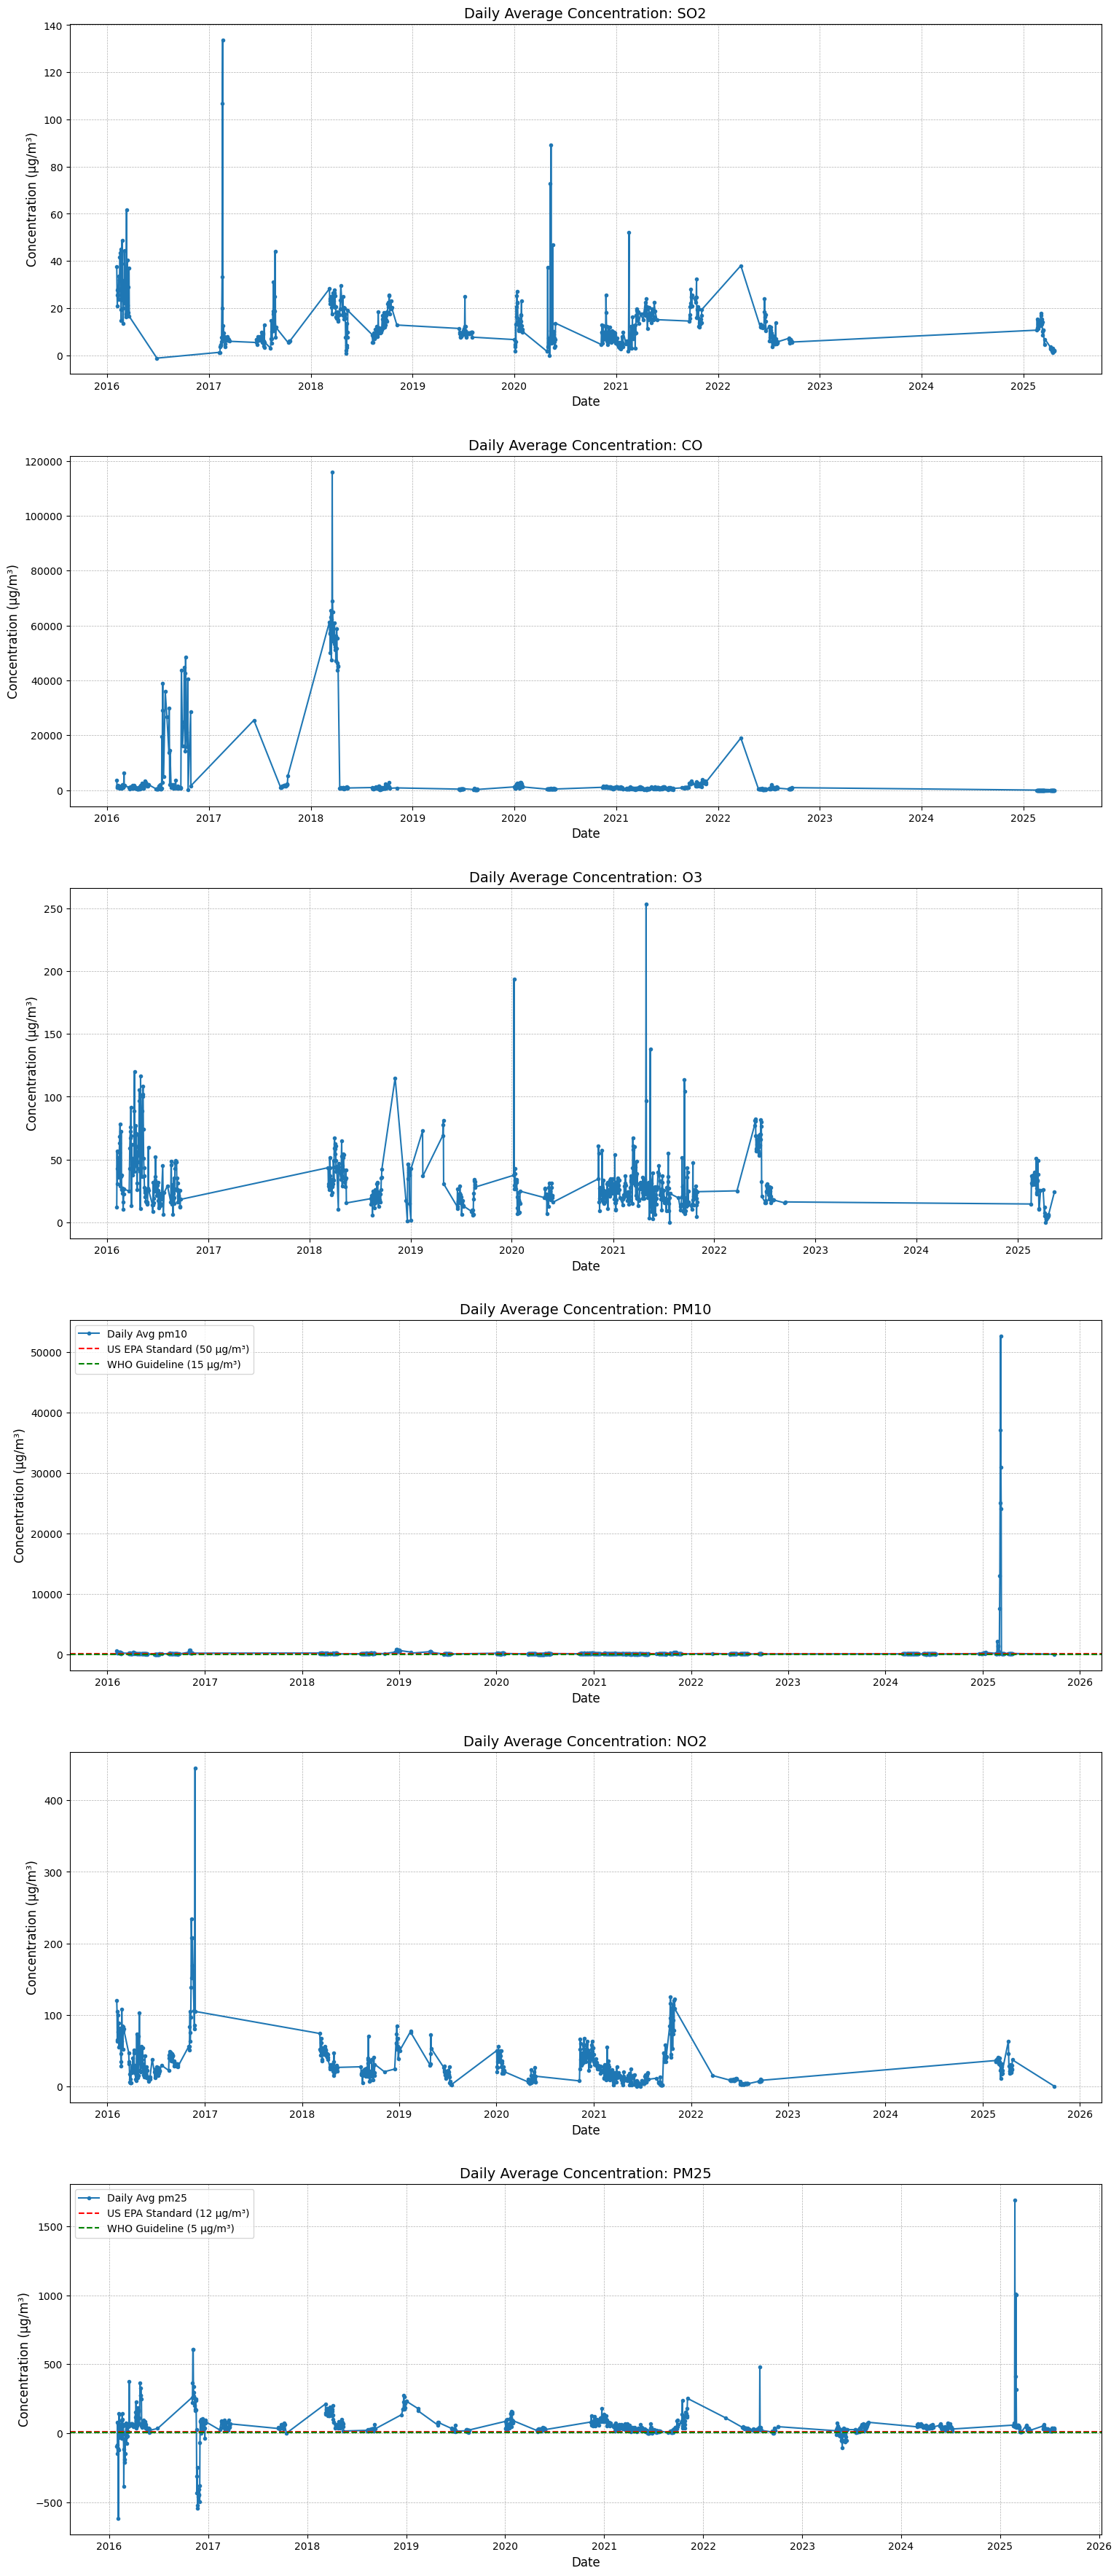


Stopping Spark session.


In [ ]:
# Step 1: Install PySpark
!pip install pyspark

# Step 2: Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg
import matplotlib.pyplot as plt
import pandas as pd

# Step 3: Create a Spark Session
# This sets up the Spark environment on your Colab instance.
try:
    spark = SparkSession.builder \
        .appName("Pollutant_TimeSeries_Analysis") \
        .master("local[*]") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()
    print("Spark Session created successfully!")
except Exception as e:
    print(f"Error creating Spark session: {e}")
    # Stop execution if Spark cannot be started
    raise

# Step 4: Upload your dataset
# This will open a file upload dialog in your browser.
from google.colab import files
print("\nPlease upload your CSV file:")
uploaded = files.upload()

# Check if a file was uploaded
if not uploaded:
    print("\nNo file uploaded. Halting execution.")
    spark.stop()
else:
    # Get the name of the uploaded file
    file_name = list(uploaded.keys())[0]
    print(f"\nFile '{file_name}' uploaded successfully.")

    try:
        # Step 5: Load the data into a Spark DataFrame
        # 'header=True' tells Spark to use the first row as column names.
        # 'inferSchema=True' automatically detects column data types.
        df = spark.read.csv(file_name, header=True, inferSchema=True)

        print("\n--- Dataset Schema ---")
        df.printSchema()
        print("\n--- Sample Data ---")
        df.show(5)

        # Step 6: Data Processing and Plotting
        # Filter out any rows where the 'value' or 'datetimeUtc' is missing
        df_filtered = df.filter(col("value").isNotNull() & col("datetimeUtc").isNotNull())

        # Get the list of unique pollutants to plot
        parameters = [row['parameter'] for row in df_filtered.select("parameter").distinct().collect()]

        if not parameters:
            print("No valid parameters found to plot.")
        else:
            print(f"\nFound parameters to plot: {', '.join(parameters)}")
            # Create a figure to hold the subplots
            plt.figure(figsize=(16, 6 * len(parameters)))

            for i, param in enumerate(parameters):
                # Filter data for the current pollutant
                param_data = df_filtered.filter(col("parameter") == param)

                if param_data.count() < 10:
                    print(f"Skipping '{param}': Not enough data points available.")
                    continue

                # Use Spark to calculate the daily average concentration
                daily_avg = param_data.withColumn("date", to_date(col("datetimeUtc"))) \
                                     .groupBy("date") \
                                     .agg(avg("value").alias("mean_value")) \
                                     .orderBy("date")

                # Convert the aggregated Spark DataFrame to a pandas DataFrame for plotting
                pdf = daily_avg.toPandas()

                # Create the subplot for this pollutant
                plt.subplot(len(parameters), 1, i + 1)
                plt.plot(pdf['date'], pdf['mean_value'], 'o-', markersize=3, label=f'Daily Avg {param}')

                # Add titles and labels
                plt.title(f"Daily Average Concentration: {param.upper()}", fontsize=14)
                plt.xlabel("Date", fontsize=12)
                unit = param_data.select('unit').first()[0] if param_data.select('unit').first() else ''
                plt.ylabel(f"Concentration ({unit})", fontsize=12)
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)

                # Add specific air quality standard lines for pm25 and pm10
                if param.lower() == 'pm25':
                    plt.axhline(y=12, color='r', linestyle='--', label='US EPA Standard (12 µg/m³)')
                    plt.axhline(y=5, color='g', linestyle='--', label='WHO Guideline (5 µg/m³)')
                    plt.legend()
                elif param.lower() == 'pm10':
                    plt.axhline(y=50, color='r', linestyle='--', label='US EPA Standard (50 µg/m³)')
                    plt.axhline(y=15, color='g', linestyle='--', label='WHO Guideline (15 µg/m³)')
                    plt.legend()

            # Adjust and display the final plots
            plt.tight_layout(pad=3.0)
            plt.show()

    except Exception as e:
        print(f"\nAn error occurred during data processing or plotting: {e}")

    finally:
        # Step 7: Stop the Spark Session
        # This releases the resources used by Spark.
        print("\nStopping Spark session.")
        spark.stop()


**CELL 11 USING DASK**

Loading data from 'combined.csv'...

--- Dask DataFrame Info ---
Columns: ['parameter', 'value', 'unit', 'datetimeUtc', 'location_id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_outlier', 'day_name']

First few rows:
  parameter   value   unit               datetimeUtc  location_id  \
0        co   570.0  µg/m³ 2016-03-22 02:15:00+00:00        412.0   
1        co   330.0  µg/m³ 2016-03-22 02:30:00+00:00        412.0   
2        co   800.0  µg/m³ 2016-03-22 02:45:00+00:00        412.0   
3        co   760.0  µg/m³ 2016-03-22 03:00:00+00:00        412.0   
4        co   960.0  µg/m³ 2016-03-22 03:15:00+00:00        412.0   
5        co   800.0  µg/m³ 2016-03-22 03:30:00+00:00        412.0   
6        co  1130.0  µg/m³ 2016-03-22 03:45:00+00:00        412.0   
7        co   910.0  µg/m³ 2016-03-22 04:00:00+00:00        412.0   
8        co  1010.0  µg/m³ 2016-03-22 04:15:00+00:00        412.0   
9        co   850.0  µg/m³ 2016-03-22 04:30:0

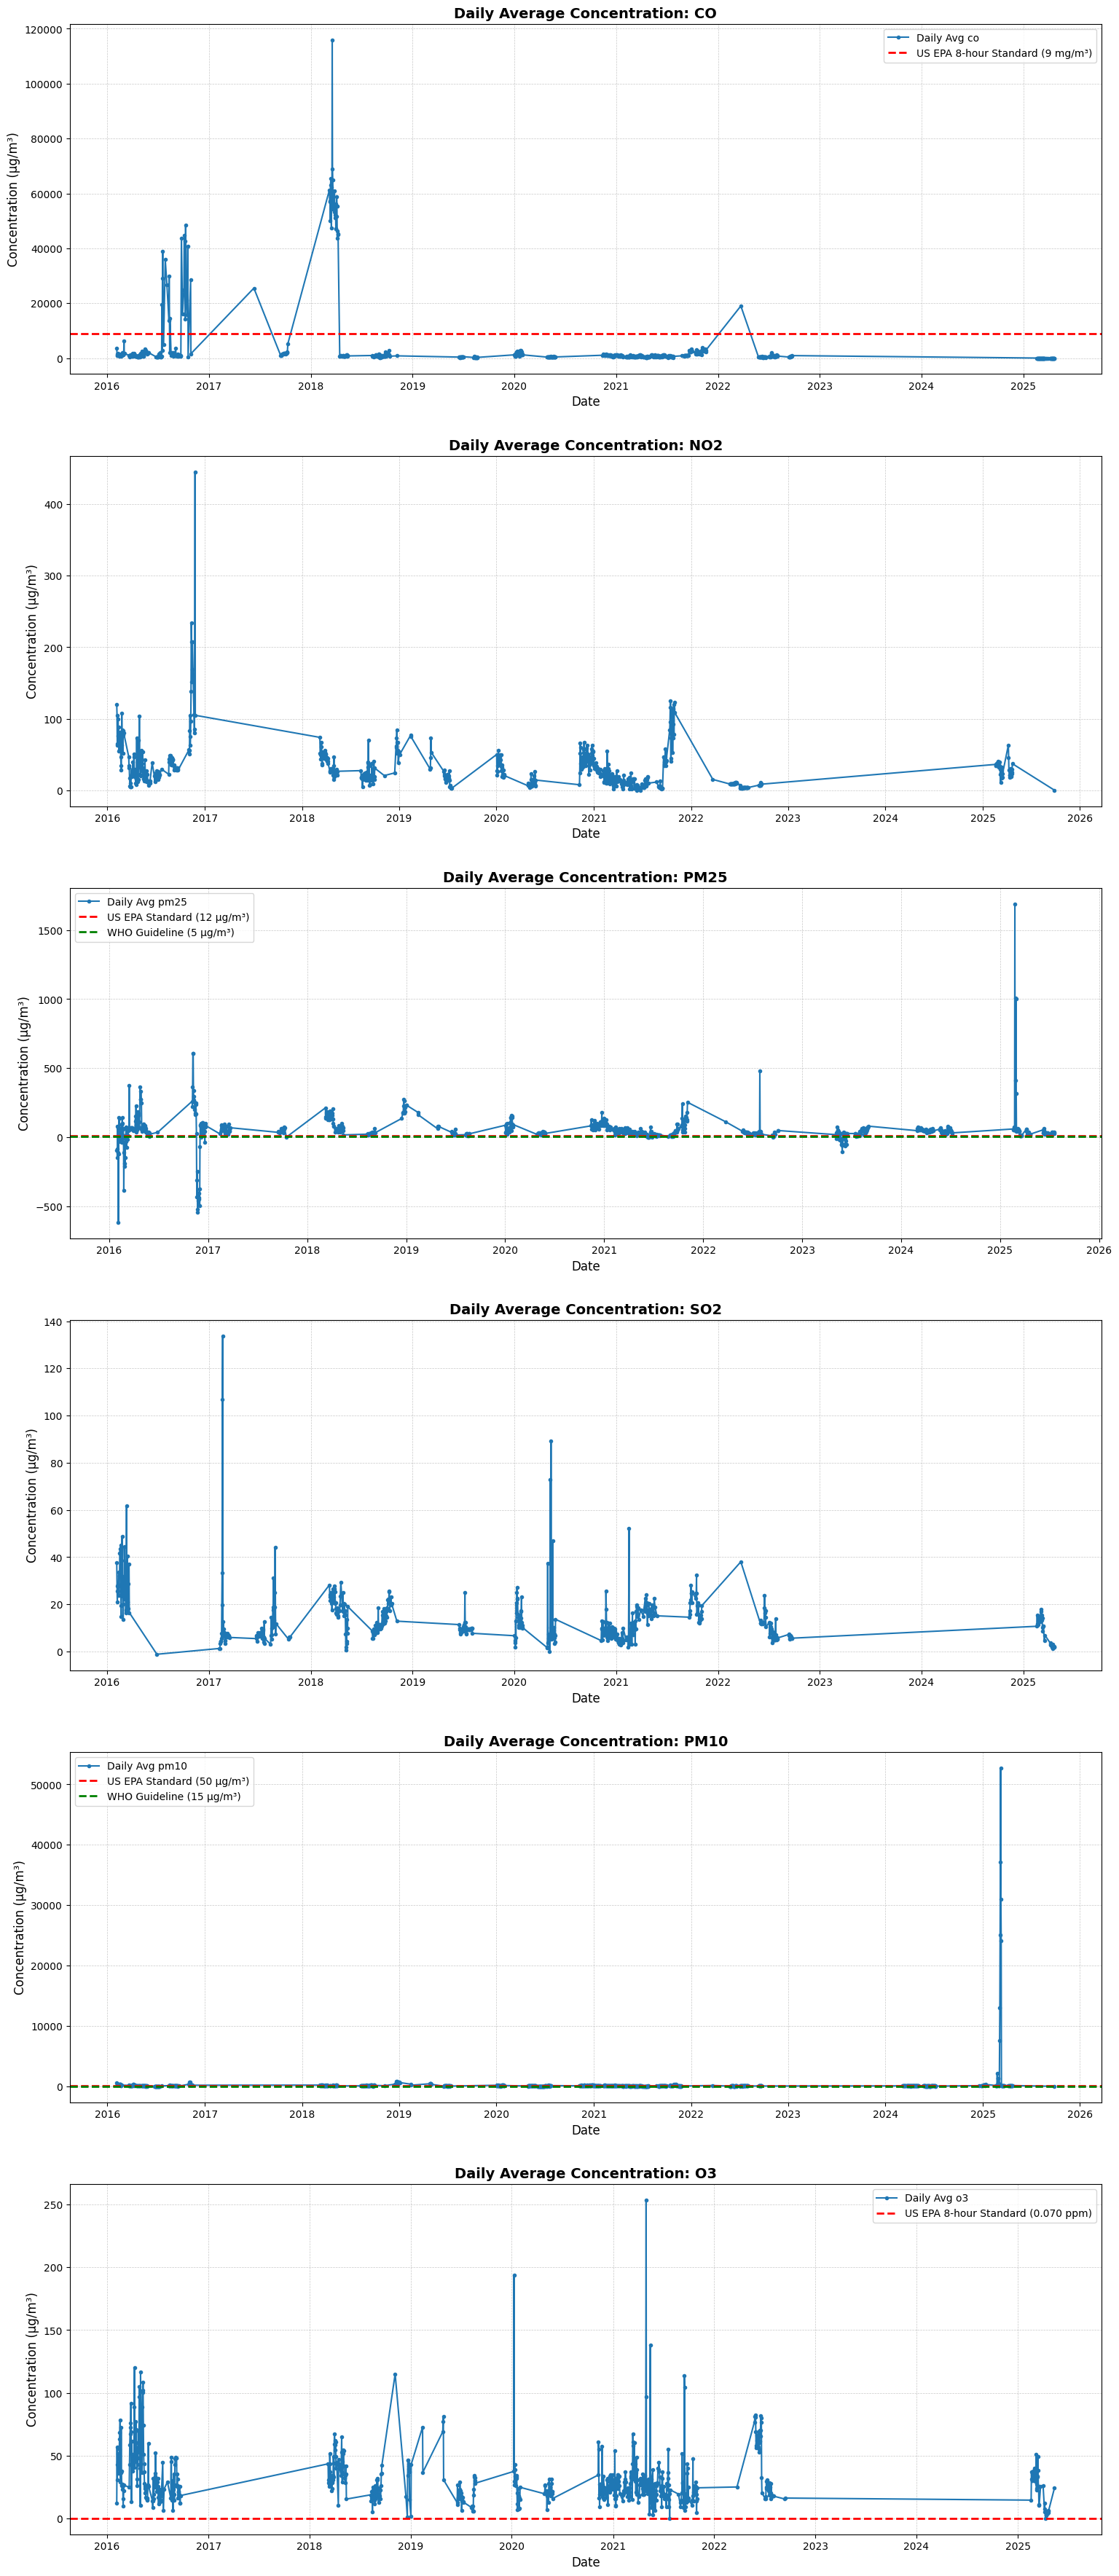


✓ Visualization complete!


In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd

# Specify your file
file_name = 'combined.csv'

print(f"Loading data from '{file_name}'...")

ddf = dd.read_csv(
    file_name,
    parse_dates=['datetimeUtc'],
    assume_missing=True
)

print("\n--- Dask DataFrame Info ---")
print(f"Columns: {ddf.columns.tolist()}")
print(f"\nFirst few rows:")
print(ddf.head(10))

# FIXED: Use isnull() == False instead of notna()
# Filter out null values
ddf_filtered = ddf[ddf['value'].isnull() == False]
ddf_filtered = ddf_filtered[ddf_filtered['datetimeUtc'].isnull() == False]

# Get unique parameters
parameters = ddf_filtered['parameter'].unique().compute()
print(f"\n--- Found Parameters ---")
print(parameters.tolist())

# Create time series plots
plt.figure(figsize=(16, 6 * len(parameters)))

for i, param in enumerate(parameters):
    print(f"\nProcessing '{param}'...")

    # Filter for current parameter
    param_ddf = ddf_filtered[ddf_filtered['parameter'] == param]

    # Check data availability
    count = len(param_ddf)
    if count < 10:
        print(f"  Skipping '{param}': Not enough data.")
        continue

    # Compute the filtered data
    param_pdf = param_ddf.compute()
    print(f"  Found {len(param_pdf)} records")

    # Process datetime and aggregate daily
    param_pdf['datetimeUtc'] = pd.to_datetime(param_pdf['datetimeUtc'])
    param_pdf['date'] = param_pdf['datetimeUtc'].dt.date

    daily_avg = param_pdf.groupby('date')['value'].mean().reset_index()
    daily_avg['date'] = pd.to_datetime(daily_avg['date'])
    daily_avg = daily_avg.sort_values('date')

    # Get unit
    unit = param_pdf['unit'].iloc[0] if 'unit' in param_pdf.columns else ''

    # Plot
    plt.subplot(len(parameters), 1, i + 1)
    plt.plot(daily_avg['date'], daily_avg['value'], 'o-',
            markersize=3, linewidth=1.5, label=f'Daily Avg {param}')

    plt.title(f"Daily Average Concentration: {param.upper()}",
             fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(f"Concentration ({unit})", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add air quality standards
    if param.lower() == 'pm25':
        plt.axhline(y=12, color='red', linestyle='--', linewidth=2,
                   label='US EPA Standard (12 µg/m³)')
        plt.axhline(y=5, color='green', linestyle='--', linewidth=2,
                   label='WHO Guideline (5 µg/m³)')
        plt.legend(loc='best')
    elif param.lower() == 'pm10':
        plt.axhline(y=50, color='red', linestyle='--', linewidth=2,
                   label='US EPA Standard (50 µg/m³)')
        plt.axhline(y=15, color='green', linestyle='--', linewidth=2,
                   label='WHO Guideline (15 µg/m³)')
        plt.legend(loc='best')
    elif param.lower() == 'o3':
        plt.axhline(y=0.070, color='red', linestyle='--', linewidth=2,
                   label='US EPA 8-hour Standard (0.070 ppm)')
        plt.legend(loc='best')
    elif param.lower() == 'co':
        plt.axhline(y=9000, color='red', linestyle='--', linewidth=2,
                   label='US EPA 8-hour Standard (9 mg/m³)')
        plt.legend(loc='best')

plt.tight_layout(pad=3.0)
plt.show()

print("\n✓ Visualization complete!")


**CELL 12 DASK**

Loading data from 'combined.csv'...

--- Data Loaded ---
Columns: ['parameter', 'value', 'unit', 'datetimeUtc', 'location_id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_outlier', 'day_name']

Found Parameters: ['co', 'no2', 'pm25', 'so2', 'pm10', 'o3']

Analyzing parameter distribution...

Processing 'co'...
  Found 124617 records

Processing 'no2'...
  Found 128454 records

Processing 'pm25'...
  Found 135223 records

Processing 'so2'...
  Found 109190 records

Processing 'pm10'...
  Found 122117 records

Processing 'o3'...
  Found 120500 records


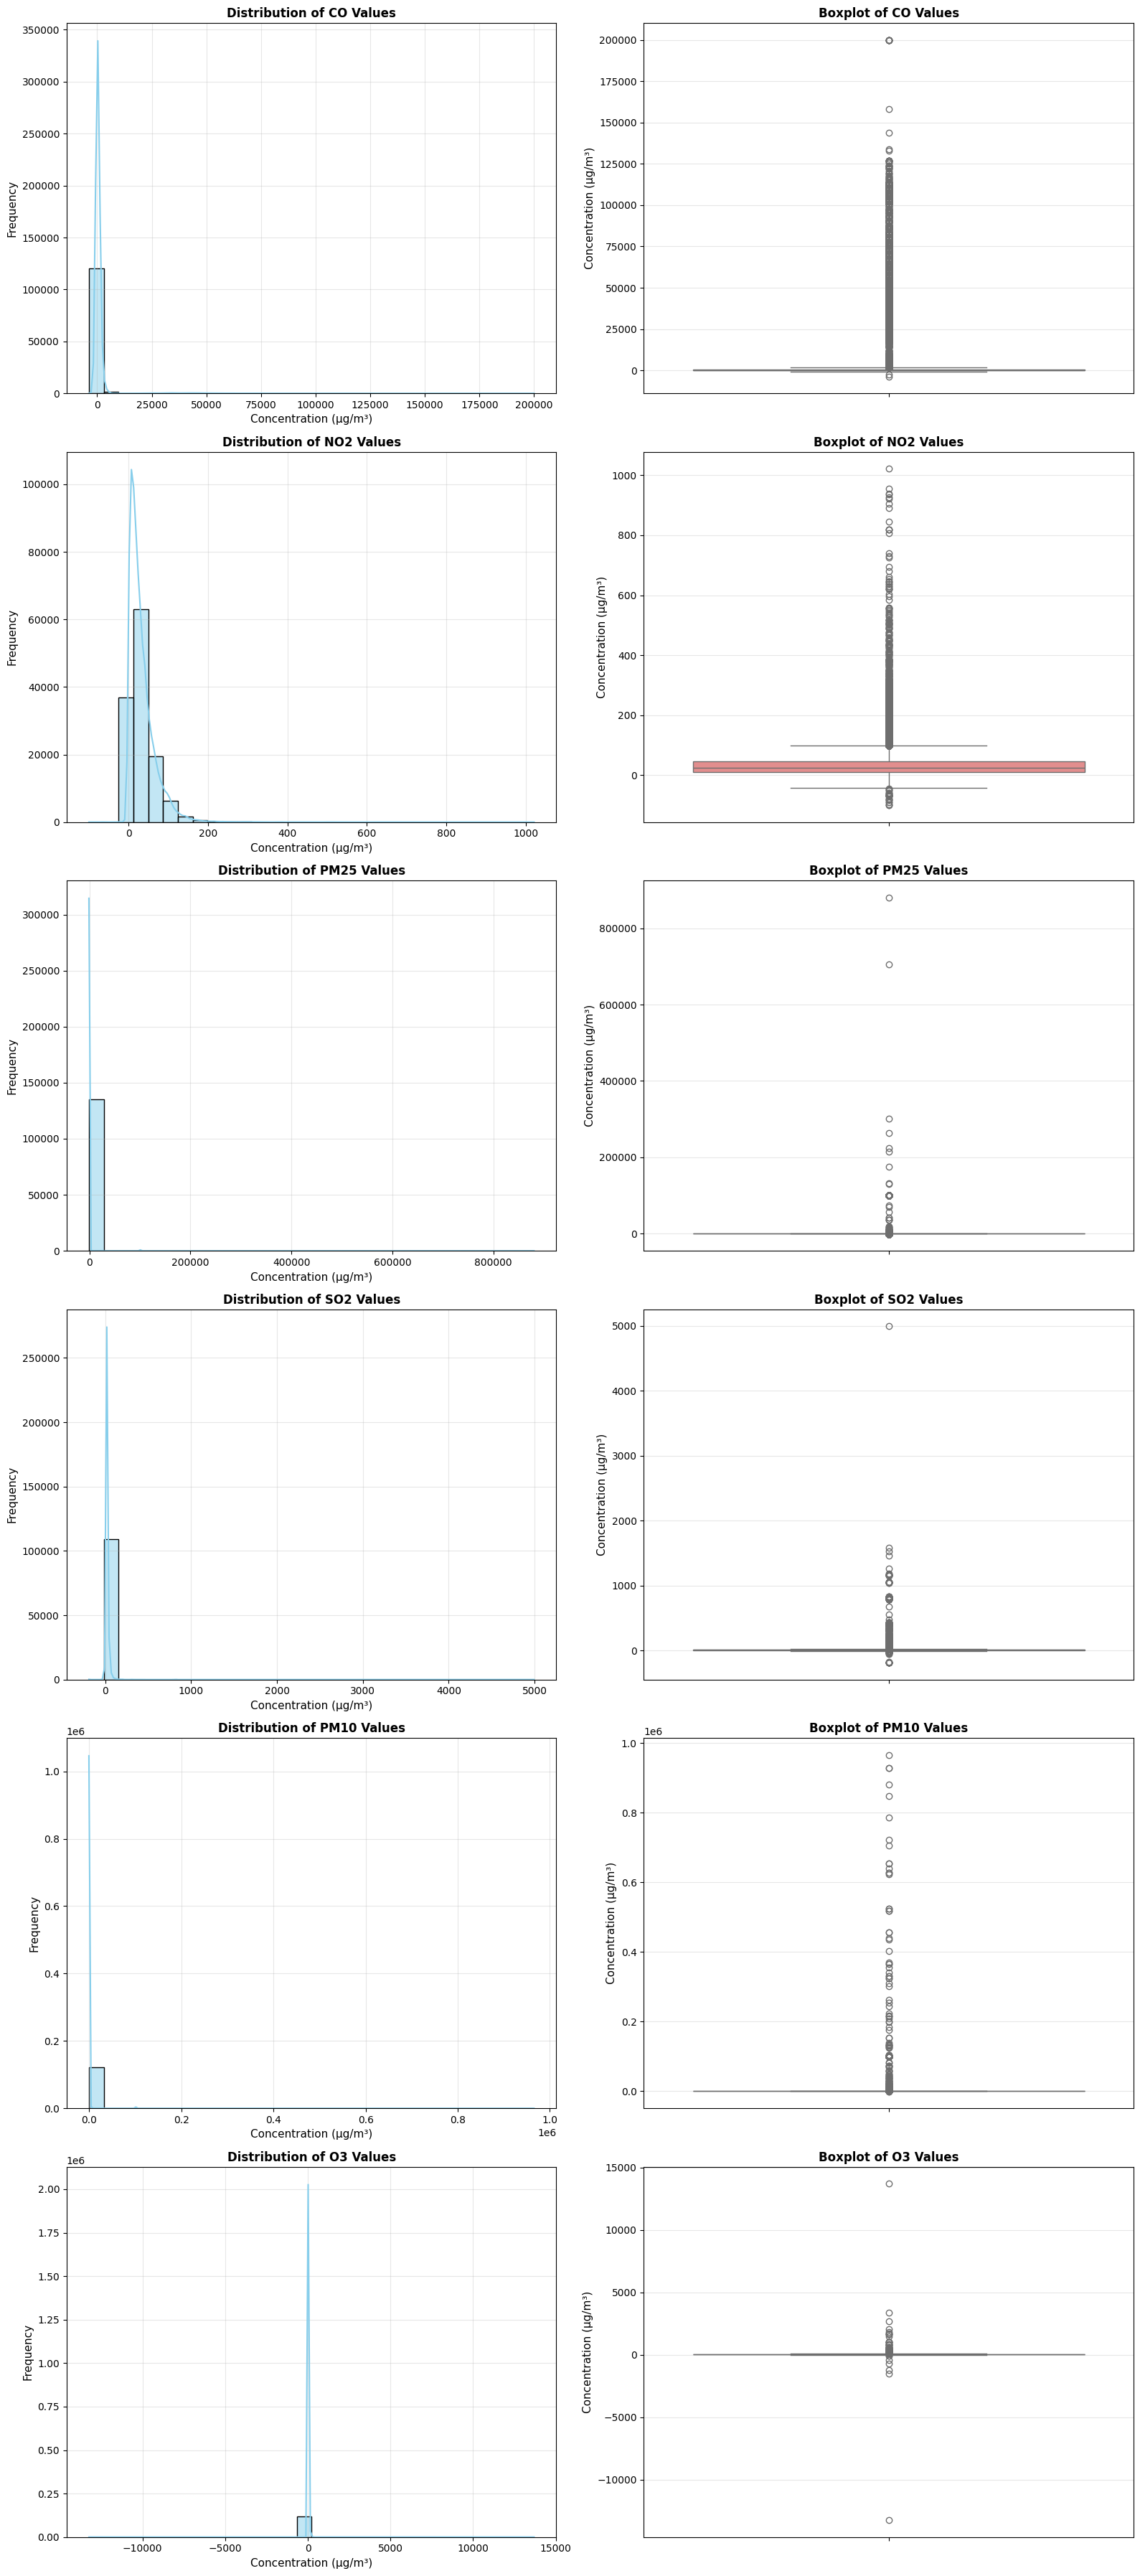


SUMMARY STATISTICS BY PARAMETER

               count         mean           std           min     25%    50%  \
parameter                                                                     
co         124617.0  1509.982261   8536.548902  -3760.000000   0.614   1.69   
no2        128454.0    33.734976     36.899817   -100.040000  10.270  23.77   
o3         120500.0    32.913323     68.798348 -13247.150000   9.600  21.87   
pm10       122117.0   839.894794  12361.113129   -679.900024  57.570  97.51   
pm25       135223.0   222.107506   5097.334572   -999.000000  28.340  45.09   
so2        109190.0    12.289259     32.302698   -189.980000   4.520   8.00   

               75%        max  
parameter                      
co         680.000  200000.00  
no2         45.610    1021.36  
o3          42.000   13692.95  
pm10       147.790  965695.69  
pm25        72.855  880552.13  
so2         13.170    4994.44  

ADDITIONAL STATISTICS

Min and Max values by parameter:
                   

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the data
file_name = 'combined.csv'
print(f"Loading data from '{file_name}'...")

ddf = dd.read_csv(file_name, parse_dates=['datetimeUtc'], assume_missing=True)

print("\n--- Data Loaded ---")
print(f"Columns: {ddf.columns.tolist()}")

# Filter out null values
ddf_filtered = ddf[ddf['value'].isnull() == False]

# Get unique parameters
parameters = ddf_filtered['parameter'].unique().compute()
print(f"\nFound Parameters: {parameters.tolist()}")

# Check if data exists
if len(parameters) > 0:
    print("\nAnalyzing parameter distribution...")

    # Create figure with subplots (2 columns: histogram and boxplot for each parameter)
    plt.figure(figsize=(16, 6 * len(parameters)))

    for i, param in enumerate(parameters):
        print(f"\nProcessing '{param}'...")

        # Filter for current parameter using Dask
        param_ddf = ddf_filtered[ddf_filtered['parameter'] == param]

        # Check data availability
        if len(param_ddf) < 10:
            print(f"  Skipping '{param}': Not enough data")
            continue

        # Compute (load into memory) the filtered data for this parameter
        param_pdf = param_ddf.compute()
        print(f"  Found {len(param_pdf)} records")

        # Get measurement unit
        unit = param_pdf['unit'].iloc[0] if 'unit' in param_pdf.columns and not param_pdf['unit'].isnull().all() else ''

        # ============================================
        # LEFT SUBPLOT: Histogram with KDE
        # ============================================
        plt.subplot(len(parameters), 2, 2*i + 1)
        sns.histplot(param_pdf['value'], kde=True, bins=30, color='skyblue', edgecolor='black')
        plt.title(f"Distribution of {param.upper()} Values", fontsize=12, fontweight='bold')
        plt.xlabel(f"Concentration ({unit})", fontsize=11)
        plt.ylabel("Frequency", fontsize=11)
        plt.grid(True, alpha=0.3)

        # ============================================
        # RIGHT SUBPLOT: Boxplot
        # ============================================
        plt.subplot(len(parameters), 2, 2*i + 2)
        sns.boxplot(y=param_pdf['value'], color='lightcoral')
        plt.title(f"Boxplot of {param.upper()} Values", fontsize=12, fontweight='bold')
        plt.ylabel(f"Concentration ({unit})", fontsize=11)
        plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # ============================================
    # SUMMARY STATISTICS
    # ============================================
    print("\n" + "="*60)
    print("SUMMARY STATISTICS BY PARAMETER")
    print("="*60)

    # Convert to pandas for groupby operations
    all_data = ddf_filtered.compute()

    # Generate statistics
    stats = all_data.groupby('parameter')['value'].describe()
    print("\n", stats)

    print("\n" + "="*60)
    print("ADDITIONAL STATISTICS")
    print("="*60)

    # Min and Max by parameter
    min_max = all_data.groupby('parameter')['value'].agg(['min', 'max'])
    print("\nMin and Max values by parameter:")
    print(min_max)

    # Skewness and Kurtosis
    print("\nSkewness and Kurtosis by parameter:")
    skew_kurt = all_data.groupby('parameter')['value'].agg([lambda x: x.skew(), lambda x: x.kurtosis()])
    skew_kurt.columns = ['Skewness', 'Kurtosis']
    print(skew_kurt)

else:
    print("No data available for distribution analysis.")

print("\n✓ Distribution analysis complete!")


**CELL 13 DASK**

Loading data from 'combined.csv'...

--- Data Loaded ---
Columns: ['parameter', 'value', 'unit', 'datetimeUtc', 'location_id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_outlier', 'day_name']

Total records: 740101

Analyzing monthly patterns...

Monthly data prepared with 72 groups

Creating combined monthly trends plot...


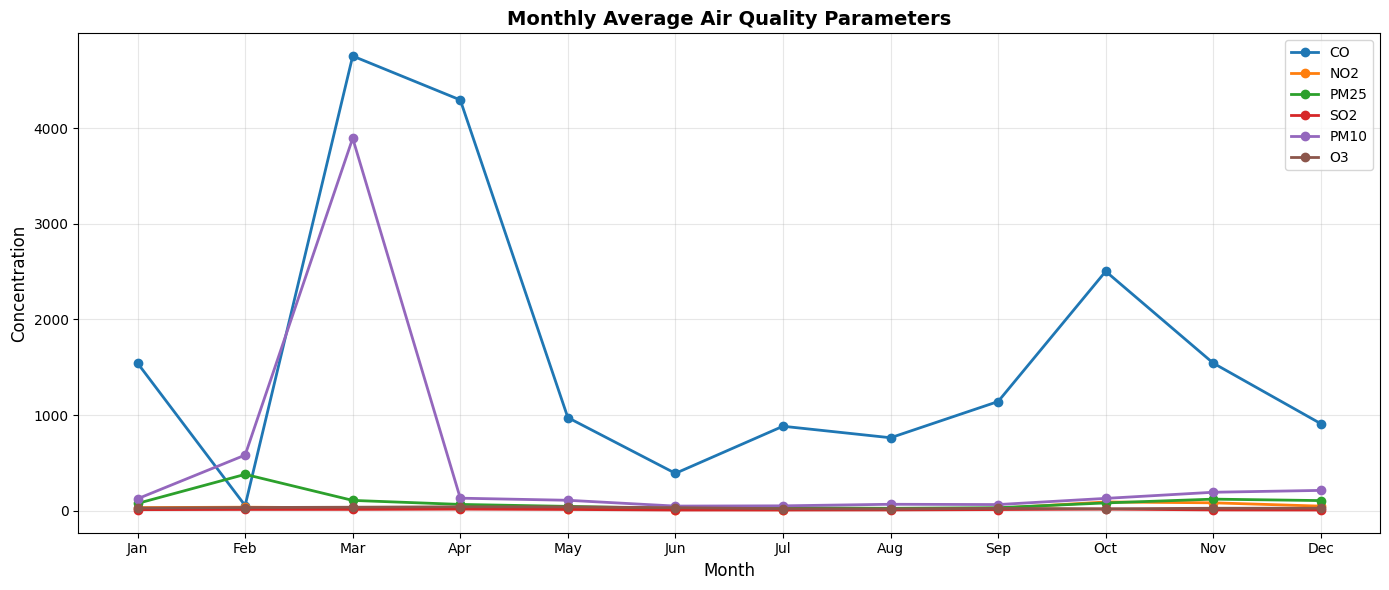


Creating individual parameter monthly trends with error bars...


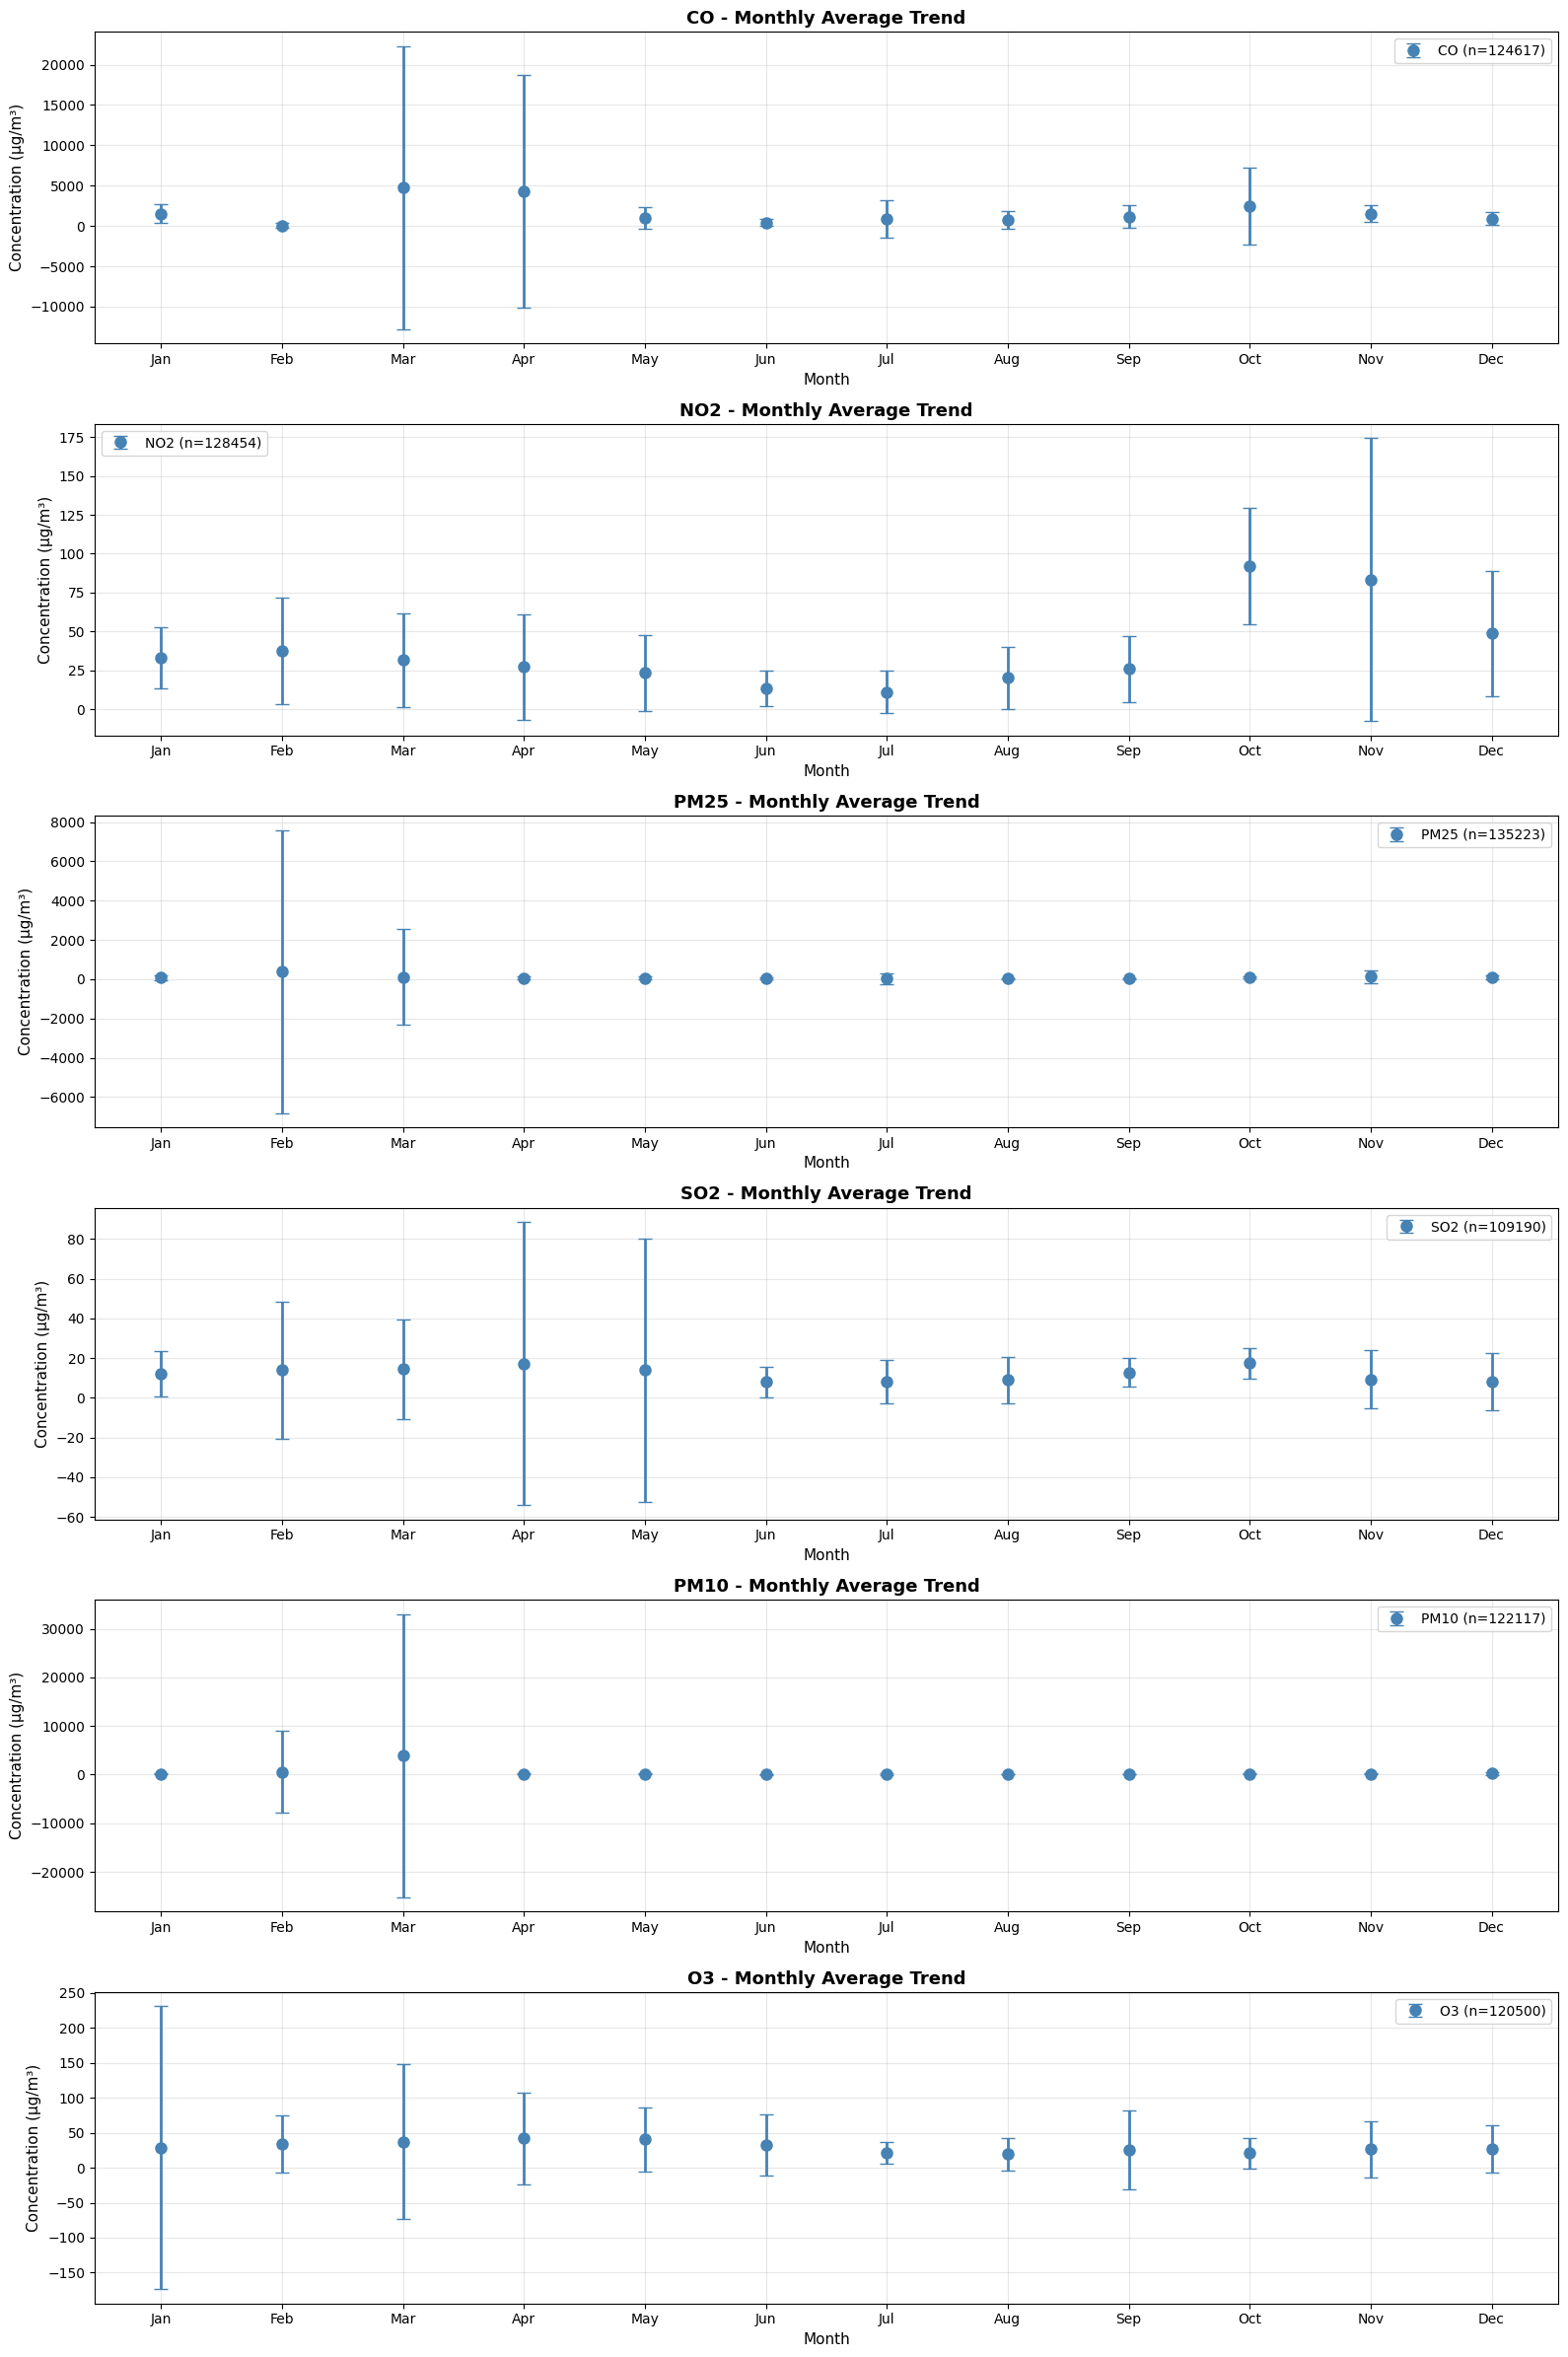


MONTHLY STATISTICS BY PARAMETER

  month parameter        mean          std  count
   1.0        co 1543.016728  1153.917489   5201
   1.0       no2   33.271676    19.752923   6965
   1.0        o3   28.610309   202.477580   4630
   1.0      pm10  125.518901   105.988990   5437
   1.0      pm25   77.085240   129.543423   5246
   1.0       so2   11.928683    11.414433   4502
   2.0        co   54.555700   299.470036  53046
   2.0       no2   37.437628    34.214943  50288
   2.0        o3   33.970184    40.712031  52358
   2.0      pm10  582.214379  8449.541309  47044
   2.0      pm25  380.748588  7208.612125  64841
   2.0       so2   13.938071    34.683715  44819
   3.0        co 4752.508852 17548.462074  19429
   3.0       no2   31.482427    29.921883  18200
   3.0        o3   37.334081   110.279631  16615
   3.0      pm10 3893.138110 29129.111940  17796
   3.0      pm25  108.436951  2444.860546  23404
   3.0       so2   14.535633    25.052647  12626
   4.0        co 4293.658688 14465

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the data
file_name = 'combined.csv'
print(f"Loading data from '{file_name}'...")

ddf = dd.read_csv(file_name, parse_dates=['datetimeUtc'], assume_missing=True)

print("\n--- Data Loaded ---")
print(f"Columns: {ddf.columns.tolist()}")

# Filter out null values
ddf_filtered = ddf[ddf['value'].isnull() == False]

# Convert to pandas for analysis (needed for groupby with multiple operations)
all_data = ddf_filtered.compute()

print(f"\nTotal records: {len(all_data)}")

# Check if 'month' column exists and has data
if 'month' not in all_data.columns or all_data['month'].isnull().all():
    print("Missing month data for analysis")
else:
    print("\nAnalyzing monthly patterns...")

    # Group by month and parameter to calculate statistics
    monthly_data = all_data.groupby(['month', 'parameter'])['value'].agg(
        ['mean', 'std', 'count']
    ).reset_index()

    print(f"\nMonthly data prepared with {len(monthly_data)} groups")

    # ============================================
    # PLOT 1: All parameters on single line plot
    # ============================================
    print("\nCreating combined monthly trends plot...")

    plt.figure(figsize=(14, 6))

    for param in all_data['parameter'].unique():
        param_monthly = monthly_data[monthly_data['parameter'] == param]

        if len(param_monthly) > 1:
            plt.plot(param_monthly['month'], param_monthly['mean'],
                    'o-', label=param.upper(), linewidth=2, markersize=6)

    plt.title('Monthly Average Air Quality Parameters', fontsize=14, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Concentration', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

    # ============================================
    # PLOT 2: Separate subplots with error bars
    # ============================================
    print("\nCreating individual parameter monthly trends with error bars...")

    parameters = all_data['parameter'].unique()
    plt.figure(figsize=(16, 4 * len(parameters)))

    for i, param in enumerate(parameters):
        param_data = monthly_data[monthly_data['parameter'] == param]

        if len(param_data) > 1:
            # Get unit for this parameter
            unit = all_data[all_data['parameter'] == param]['unit'].iloc[0] \
                   if 'unit' in all_data.columns else ''

            # Subplot with error bars
            plt.subplot(len(parameters), 1, i + 1)

            plt.errorbar(param_data['month'], param_data['mean'],
                        yerr=param_data['std'],
                        fmt='o', capsize=5, linewidth=2, markersize=8,
                        label=f"{param.upper()} (n={int(param_data['count'].sum())})",
                        color='steelblue')

            plt.title(f"{param.upper()} - Monthly Average Trend",
                     fontsize=13, fontweight='bold')
            plt.xlabel('Month', fontsize=11)
            plt.ylabel(f'Concentration ({unit})', fontsize=11)
            plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.grid(True, alpha=0.3)
            plt.legend(loc='best', fontsize=10)

    plt.tight_layout()
    plt.show()

    # ============================================
    # SUMMARY STATISTICS
    # ============================================
    print("\n" + "="*70)
    print("MONTHLY STATISTICS BY PARAMETER")
    print("="*70)

    print("\n", monthly_data.to_string(index=False))

    # Month-wise summary
    print("\n" + "="*70)
    print("MONTHLY SUMMARY (All Parameters Combined)")
    print("="*70)

    monthly_summary = all_data.groupby('month')['value'].agg(['mean', 'std', 'count'])
    print("\n", monthly_summary)

    # Parameter-wise summary
    print("\n" + "="*70)
    print("PARAMETER SUMMARY (All Months Combined)")
    print("="*70)

    param_summary = all_data.groupby('parameter')['value'].agg(['mean', 'std', 'count', 'min', 'max'])
    print("\n", param_summary)

print("\n✓ Monthly patterns analysis complete!")


**CELL 14 DASK**

Loading data from 'combined.csv'...

--- Data Loaded ---
Columns: ['parameter', 'value', 'unit', 'datetimeUtc', 'location_id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_outlier', 'day_name']

Total records: 740101
Data types:
parameter            string[pyarrow]
value                        float64
unit                 string[pyarrow]
datetimeUtc      datetime64[ns, UTC]
location_id                  float64
location_name        string[pyarrow]
latitude                     float64
longitude                    float64
year                         float64
month                        float64
day                          float64
hour                         float64
dayofweek                    float64
is_outlier                      bool
day_name             string[pyarrow]
dtype: object
Records after cleaning: 740101

Dayofweek values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.

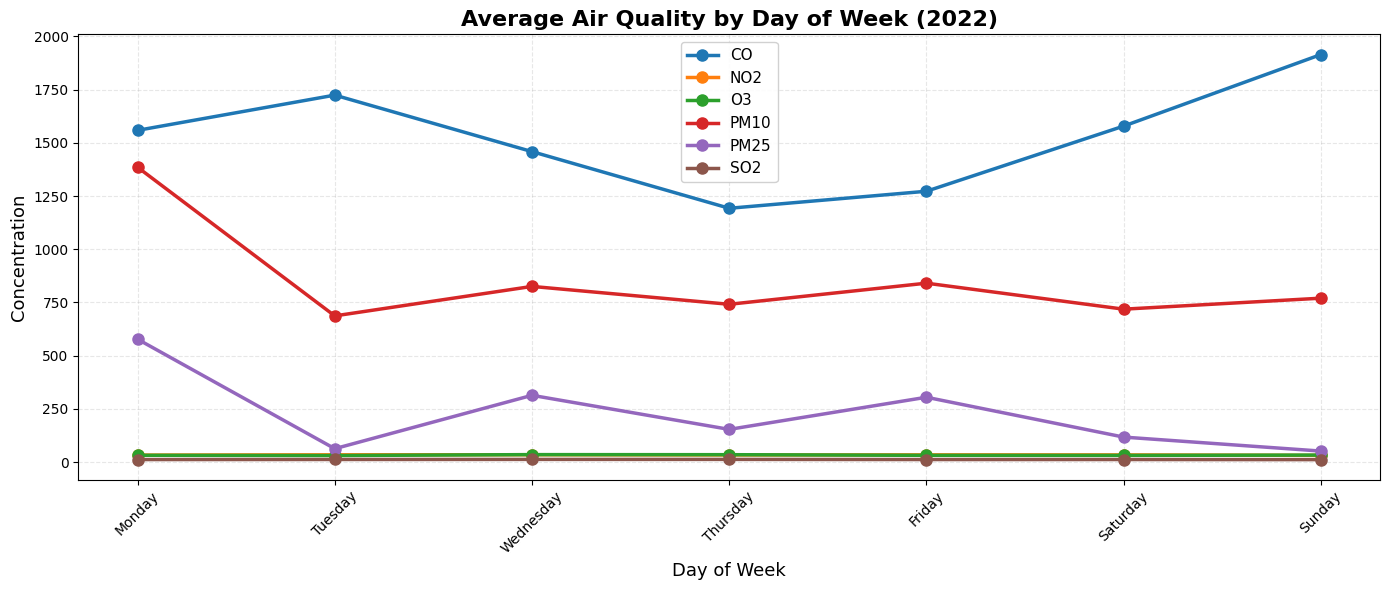


Creating individual parameter daily trends with error bars...
  Subplot for co: 7 data points
  Subplot for no2: 7 data points
  Subplot for o3: 7 data points
  Subplot for pm10: 7 data points
  Subplot for pm25: 7 data points
  Subplot for so2: 7 data points


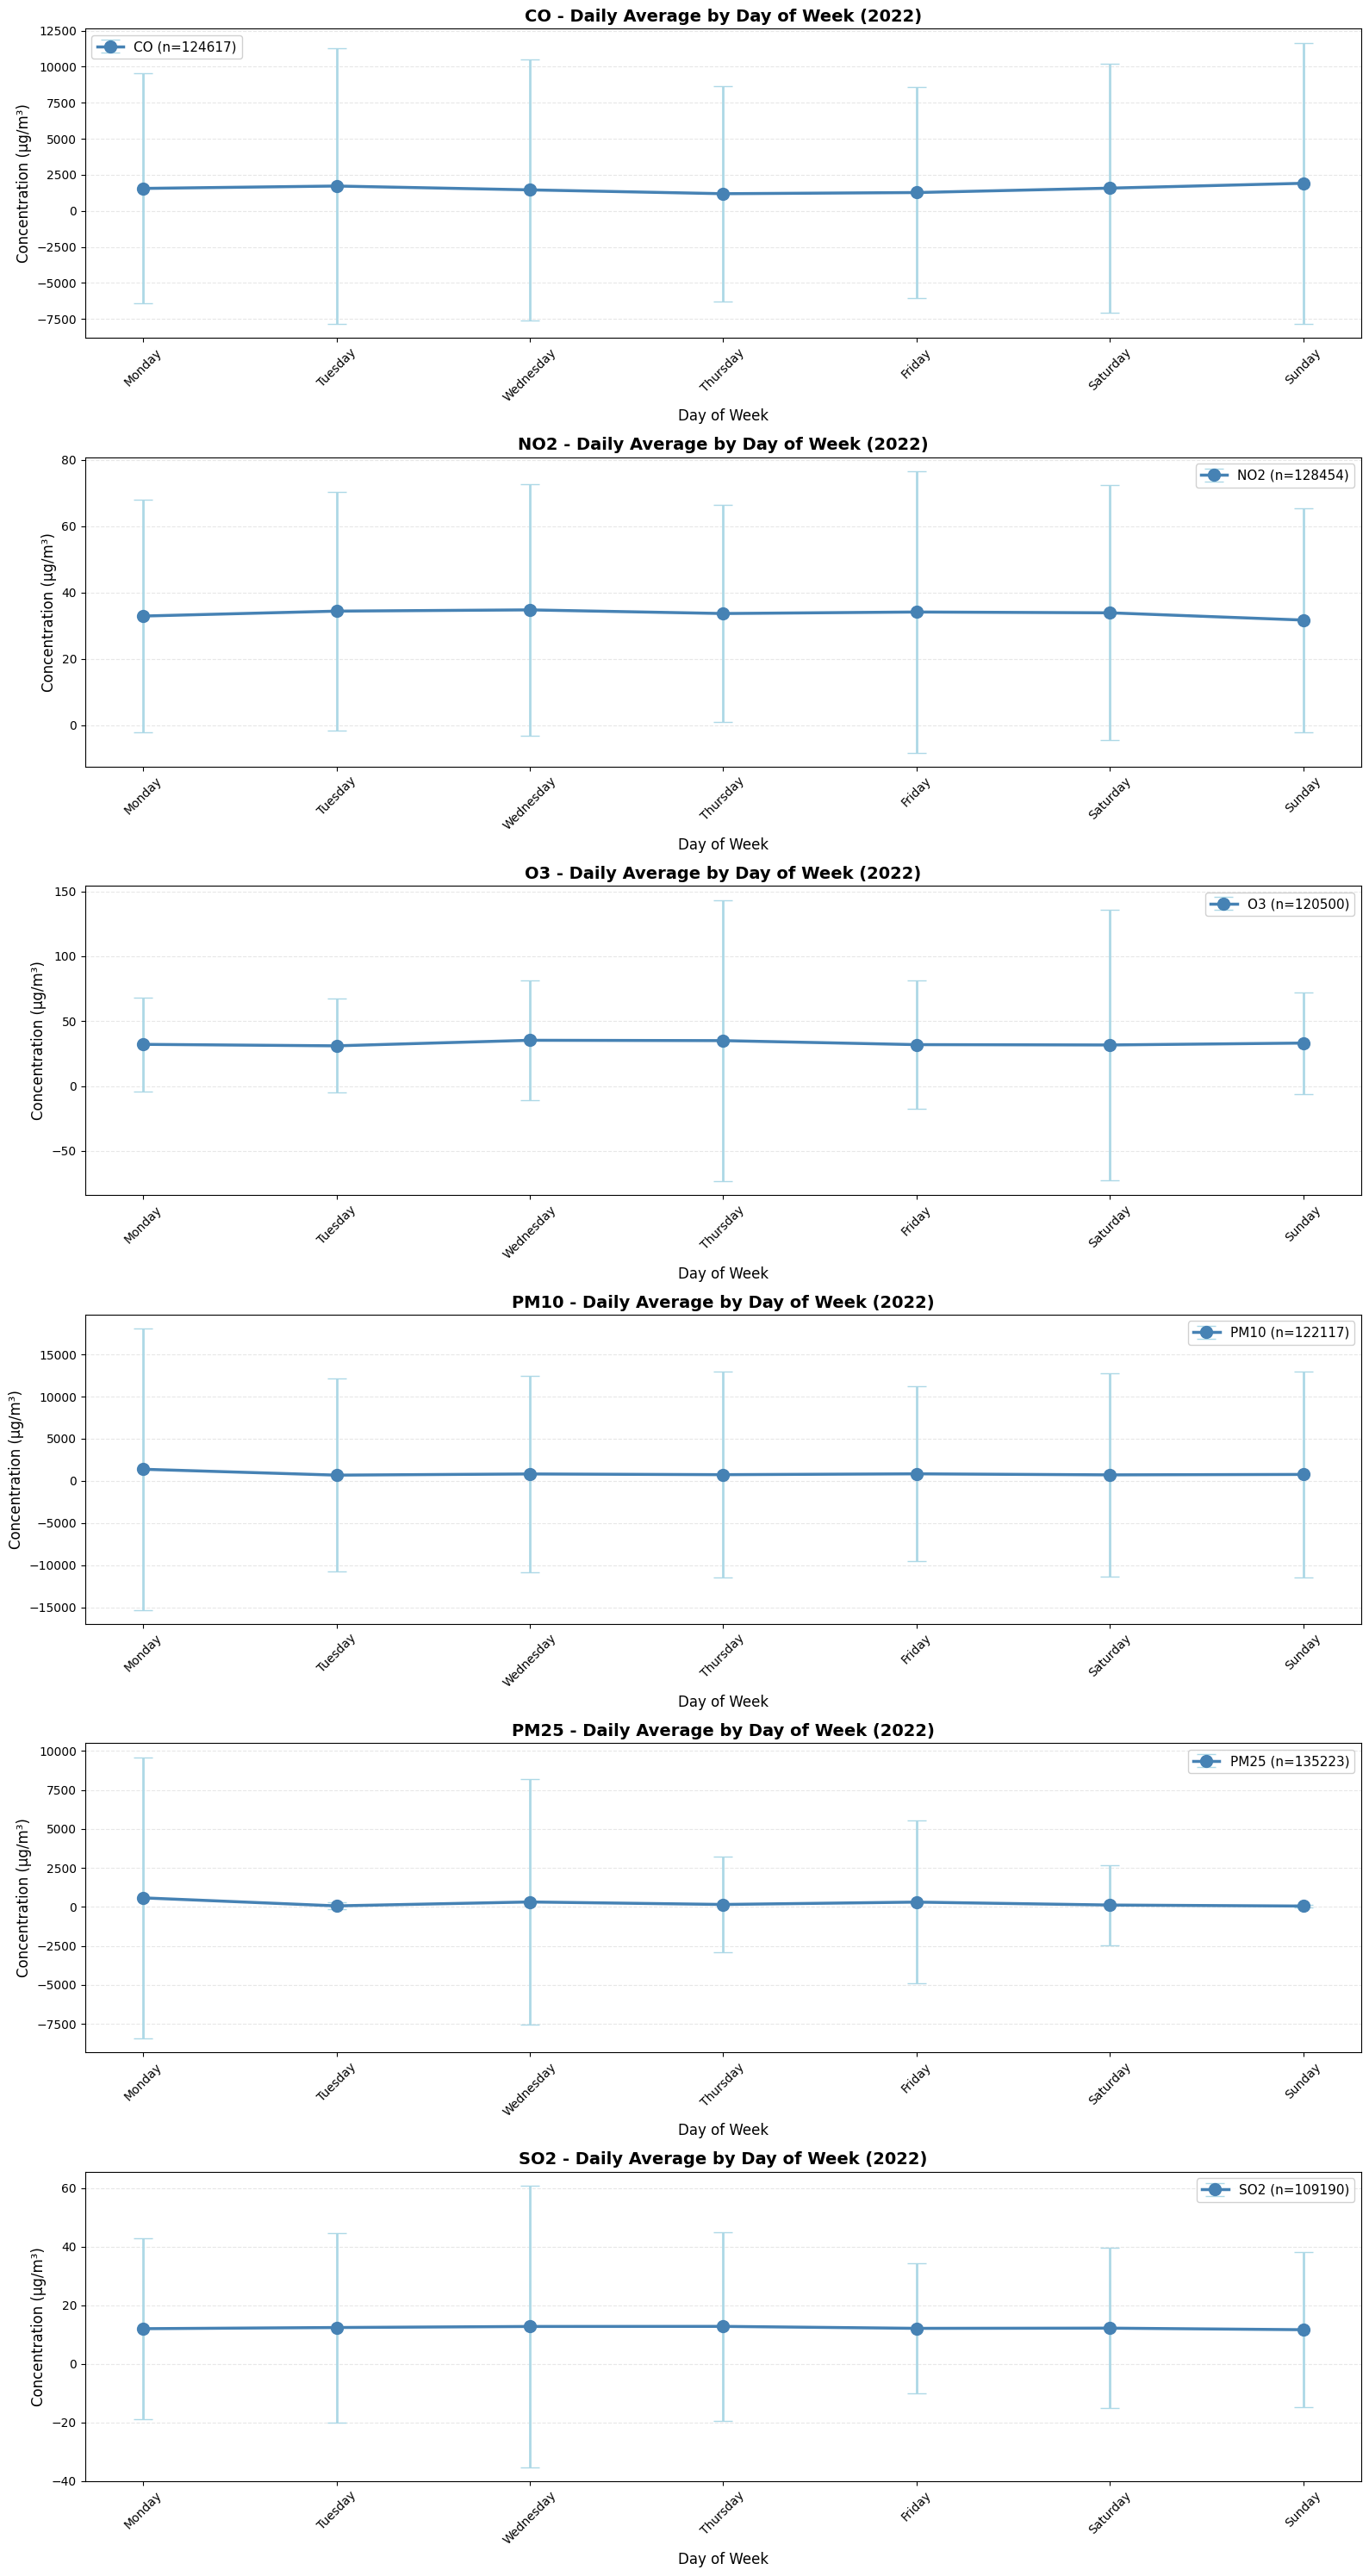


DAILY STATISTICS BY PARAMETER

  day_name parameter        mean          std  count
   Friday        co 1272.415654  7307.034558  20196
   Monday        co 1558.514474  7981.897389  15047
 Saturday        co 1578.424731  8635.888443  19347
   Sunday        co 1914.406346  9742.434951  15987
 Thursday        co 1192.476192  7485.805801  19361
  Tuesday        co 1724.019195  9566.638503  15850
Wednesday        co 1458.609180  9050.216580  18829
   Friday       no2   34.172956    42.382623  20524
   Monday       no2   32.953858    34.997428  15903
 Saturday       no2   33.932283    38.485434  19565
   Sunday       no2   31.743974    33.755702  16482
 Thursday       no2   33.716791    32.679843  19849
  Tuesday       no2   34.439185    35.877375  16656
Wednesday       no2   34.814311    37.957071  19475
   Friday        o3   31.893876    49.611408  19055
   Monday        o3   32.118507    36.051075  14548
 Saturday        o3   31.642774   104.029168  18799
   Sunday        o3   33.103631

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the data
file_name = 'combined.csv'
print(f"Loading data from '{file_name}'...")

ddf = dd.read_csv(file_name, parse_dates=['datetimeUtc'], assume_missing=True)

print("\n--- Data Loaded ---")
print(f"Columns: {ddf.columns.tolist()}")

# Filter out null values
ddf_filtered = ddf[ddf['value'].isnull() == False]

# Convert to pandas for analysis
all_data = ddf_filtered.compute()

print(f"\nTotal records: {len(all_data)}")
print(f"Data types:\n{all_data.dtypes}")

# ============================================
# DATA CLEANING & PREPARATION - CRITICAL!
# ============================================

# Ensure dayofweek is numeric
all_data['dayofweek'] = pd.to_numeric(all_data['dayofweek'], errors='coerce')

# Ensure value is numeric
all_data['value'] = pd.to_numeric(all_data['value'], errors='coerce')

# Remove rows with NaN in critical columns
all_data = all_data.dropna(subset=['dayofweek', 'value', 'parameter'])

print(f"Records after cleaning: {len(all_data)}")
print(f"\nDayofweek values: {sorted(all_data['dayofweek'].unique())}")
print(f"Parameters: {all_data['parameter'].unique()}")

# Check if 'dayofweek' column exists and has data
if 'dayofweek' not in all_data.columns or all_data['dayofweek'].isnull().all():
    print("Missing day of week data for analysis")
else:
    print("\nAnalyzing daily patterns...")

    # Group by day of week and parameter
    daily_data = all_data.groupby(['dayofweek', 'parameter'])['value'].agg(
        ['mean', 'std', 'count']
    ).reset_index()

    # Convert to float to ensure plotting works
    daily_data['mean'] = daily_data['mean'].astype(float)
    daily_data['std'] = daily_data['std'].astype(float)
    daily_data['dayofweek'] = daily_data['dayofweek'].astype(int)

    # Map day numbers to day names
    day_names = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }

    daily_data['day_name'] = daily_data['dayofweek'].map(day_names)

    print(f"Daily data prepared with {len(daily_data)} groups")
    print("\nDaily Data Sample:")
    print(daily_data.head(10))

    # ============================================
    # PLOT 1: All parameters on single plot
    # ============================================
    print("\n" + "="*70)
    print("Creating combined daily trends plot...")
    print("="*70)

    plt.figure(figsize=(14, 6))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    for idx, param in enumerate(sorted(all_data['parameter'].unique())):
        param_daily = daily_data[daily_data['parameter'] == param].copy()
        param_daily = param_daily.sort_values('dayofweek')

        print(f"  Plotting {param}: {len(param_daily)} data points")

        if len(param_daily) >= 1:
            plt.plot(param_daily['dayofweek'], param_daily['mean'],
                    'o-', label=param.upper(), linewidth=2.5, markersize=8,
                    color=colors[idx % len(colors)])

    plt.title('Average Air Quality by Day of Week (2022)', fontsize=16, fontweight='bold')
    plt.xlabel('Day of Week', fontsize=13)
    plt.ylabel('Concentration', fontsize=13)
    plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                          'Friday', 'Saturday', 'Sunday'], rotation=45)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='best', fontsize=11, framealpha=0.9)
    plt.tight_layout()
    plt.show()

    # ============================================
    # PLOT 2: Separate subplots with error bars
    # ============================================
    print("\n" + "="*70)
    print("Creating individual parameter daily trends with error bars...")
    print("="*70)

    parameters = sorted(all_data['parameter'].unique())
    num_params = len(parameters)

    plt.figure(figsize=(16, 5 * num_params))

    for i, param in enumerate(parameters):
        param_data = daily_data[daily_data['parameter'] == param].copy()
        param_data = param_data.sort_values('dayofweek')

        print(f"  Subplot for {param}: {len(param_data)} data points")

        if len(param_data) >= 1:
            # Get unit
            unit_val = all_data[all_data['parameter'] == param]['unit'].iloc[0] \
                       if 'unit' in all_data.columns else ''

            # Count of records
            record_count = int(param_data['count'].sum())

            # Subplot with error bars
            plt.subplot(num_params, 1, i + 1)

            plt.errorbar(param_data['dayofweek'], param_data['mean'],
                        yerr=param_data['std'],
                        fmt='o-', capsize=8, linewidth=2.5, markersize=10,
                        label=f"{param.upper()} (n={record_count})",
                        color='steelblue', ecolor='lightblue', elinewidth=2)

            plt.title(f"{param.upper()} - Daily Average by Day of Week (2022)",
                     fontsize=14, fontweight='bold')
            plt.xlabel('Day of Week', fontsize=12)
            plt.ylabel(f'Concentration ({unit_val})', fontsize=12)
            plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                   'Friday', 'Saturday', 'Sunday'], rotation=45)
            plt.grid(True, alpha=0.3, linestyle='--', axis='y')
            plt.legend(loc='best', fontsize=11, framealpha=0.9)

    plt.tight_layout()
    plt.show()

    # ============================================
    # SUMMARY STATISTICS
    # ============================================
    print("\n" + "="*70)
    print("DAILY STATISTICS BY PARAMETER")
    print("="*70)

    daily_data_display = daily_data.copy()
    display_df = daily_data_display[['day_name', 'parameter', 'mean', 'std', 'count']].copy()
    display_df = display_df.sort_values(['parameter', 'day_name'])

    print("\n", display_df.to_string(index=False))

    # ============================================
    # WEEKDAY vs WEEKEND COMPARISON
    # ============================================
    print("\n" + "="*70)
    print("WEEKDAY vs WEEKEND COMPARISON")
    print("="*70)

    # Mark weekends (Saturday=5, Sunday=6)
    all_data_copy = all_data.copy()
    all_data_copy['is_weekend'] = all_data_copy['dayofweek'].isin([5, 6])

    # Group by weekend flag and parameter
    weekday_weekend = all_data_copy.groupby(['is_weekend', 'parameter'])['value'].agg(
        ['mean', 'std', 'count']
    ).reset_index()

    # Map to period names
    weekday_weekend['period'] = weekday_weekend['is_weekend'].map(
        {False: 'Weekday', True: 'Weekend'}
    )

    # Create pivot table
    weekday_weekend_pivot = weekday_weekend.pivot(
        index='parameter',
        columns='period',
        values='mean'
    )

    # Calculate percentage difference
    weekday_weekend_pivot['Difference (%)'] = (
        (weekday_weekend_pivot['Weekend'] - weekday_weekend_pivot['Weekday']) /
        weekday_weekend_pivot['Weekday'] * 100
    )

    print("\n", weekday_weekend_pivot.round(2))

    # Detailed comparison
    print("\n" + "="*70)
    print("DETAILED WEEKDAY vs WEEKEND STATISTICS")
    print("="*70)

    weekday_weekend_sorted = weekday_weekend.sort_values(['period', 'parameter'])
    print("\n", weekday_weekend_sorted.to_string(index=False))

    # ============================================
    # KEY INSIGHTS
    # ============================================
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)

    for param in parameters:
        try:
            weekday_val = weekday_weekend_pivot.loc[param, 'Weekday']
            weekend_val = weekday_weekend_pivot.loc[param, 'Weekend']
            diff_pct = weekday_weekend_pivot.loc[param, 'Difference (%)']

            if diff_pct > 0:
                direction = "HIGHER"
            else:
                direction = "LOWER"

            print(f"\n{param.upper()}:")
            print(f"  Weekday average:   {weekday_val:.4f}")
            print(f"  Weekend average:   {weekend_val:.4f}")
            print(f"  Weekend is {abs(diff_pct):.1f}% {direction} than weekday")
        except Exception as e:
            print(f"\nCould not calculate for {param}: {e}")

print("\n" + "="*70)
print("✓ Daily patterns analysis complete!")
print("="*70)


**CSLL 16 DASK**

Loading data from 'combined.csv'...

--- Data Loaded ---
Columns: ['parameter', 'value', 'unit', 'datetimeUtc', 'location_id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_outlier', 'day_name']

Total records: 740101
Records after cleaning: 740101

Locations: <ArrowStringArray>
[                    'Peenya, Bengaluru - KSPCB',
                 'BTM Layout, Bengaluru - KSPCB',
                  'City Railway Station - KSPCB',
                       'SaneguravaHalli - KSPCB',
      'BWSSB Kadabesanahalli, Bengaluru - KSPCB',
       'BWSSB Kadabesanahalli, Bengaluru - CPCB',
                  'BTM Layout, Bengaluru - CPCB',
       'City Railway Station, Bengaluru - KSPCB',
                      'Peenya, Bengaluru - CPCB',
           'Sanegurava Halli, Bengaluru - KSPCB',
 ...
                      'MIT-Kothrud, Pune - IITM',
          'Gavalinagar, Pimpri Chinchwad - MPCB',
    'Park Street Wakad, Pimpri Chinchwad - MPCB',
             'Therga

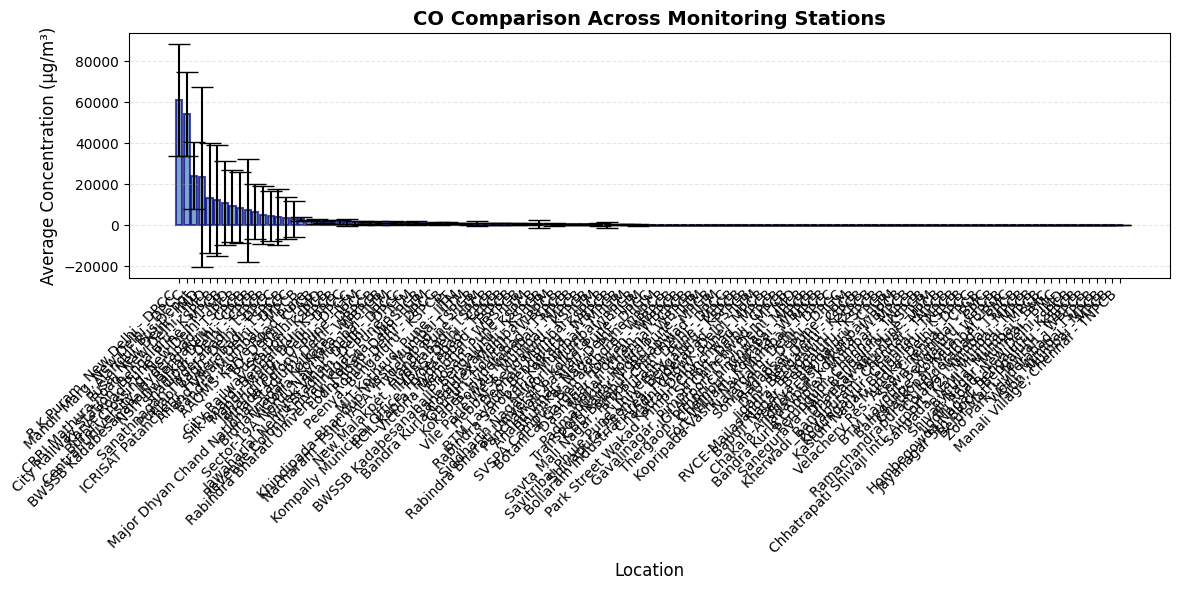


Numerical comparison for CO across locations:

                                              Location         Mean      Std Dev  Count
                          R K Puram, New Delhi - DPCC 60912.039801 27289.805355    201
                        Mandir Marg, New Delhi - DPCC 54152.631579 20525.799185    190
                                    Alandur Bus Depot 24198.640777 16202.692650    103
                                Pusa, New Delhi - IMD 23561.596548 43792.411108    927
                   CRRI Mathura Road, New Delhi - IMD 13326.280000 26657.866888   1000
              City Railway Station, Bengaluru - KSPCB 12091.610000 27152.252808   1000
                         Karve Road Pune, Pune - MPCB 10841.360000 20448.751531   1000
                     Burari Crossing, New Delhi - IMD  9471.930000 17519.566941   1000
                Central University, Hyderabad - TSPCB  8549.990000 17481.200882   1000
              BWSSB Kadabesanahalli, Bengaluru - CPCB  7227.220000 25274.085940  

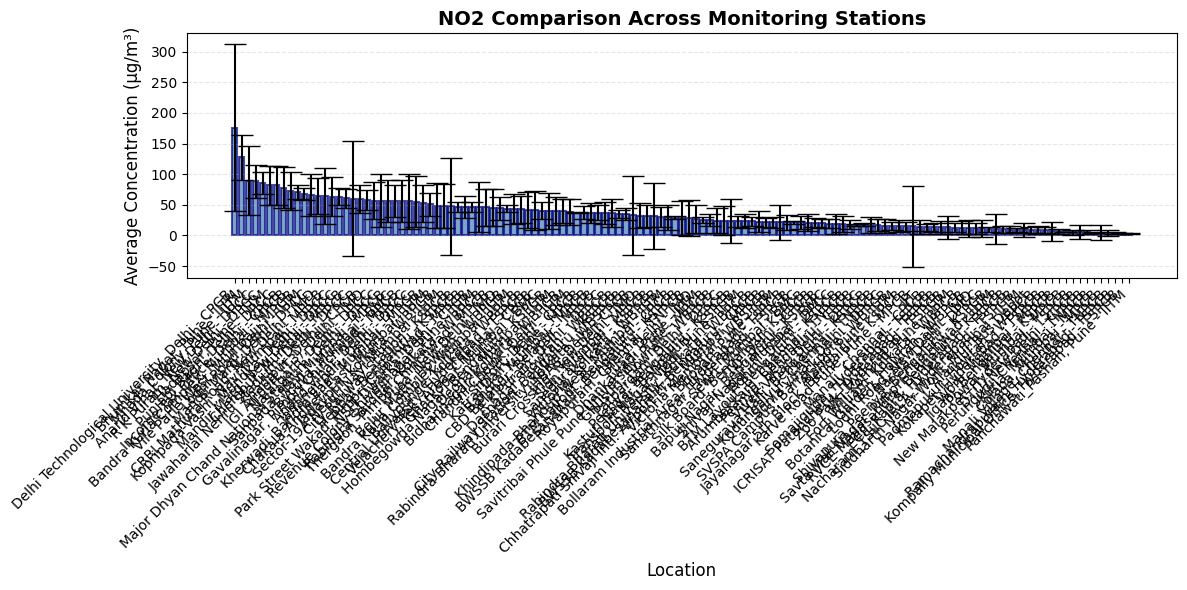


Numerical comparison for NO2 across locations:

                                              Location       Mean    Std Dev  Count
         Delhi Technological University, Delhi - CPCB 176.184900 135.617953   1000
                           Bhumkar Nagar, Pune - IITM 127.698110  36.428572   1000
                            Mhada Colony, Pune - IITM  89.226820  56.448861   1000
                        Anand Vihar, New Delhi - DPCC  88.499400  27.157238   1000
                          R K Puram, New Delhi - DPCC  85.483030  18.017490    165
                                Hadapsar, Pune - IITM  81.883380  32.080708   1000
                           Punjabi Bagh, Delhi - DPCC  81.673406  32.144528   1057
                      Income Tax Office, Delhi - CPCB  77.975000  33.067240   1000
                  Bandra Kurla Complex, Mumbai - MPCB  72.382690  30.623189   1000
                       Vile Parle West, Mumbai - MPCB  71.039560  11.839296   1000
                             Lodhi Ro

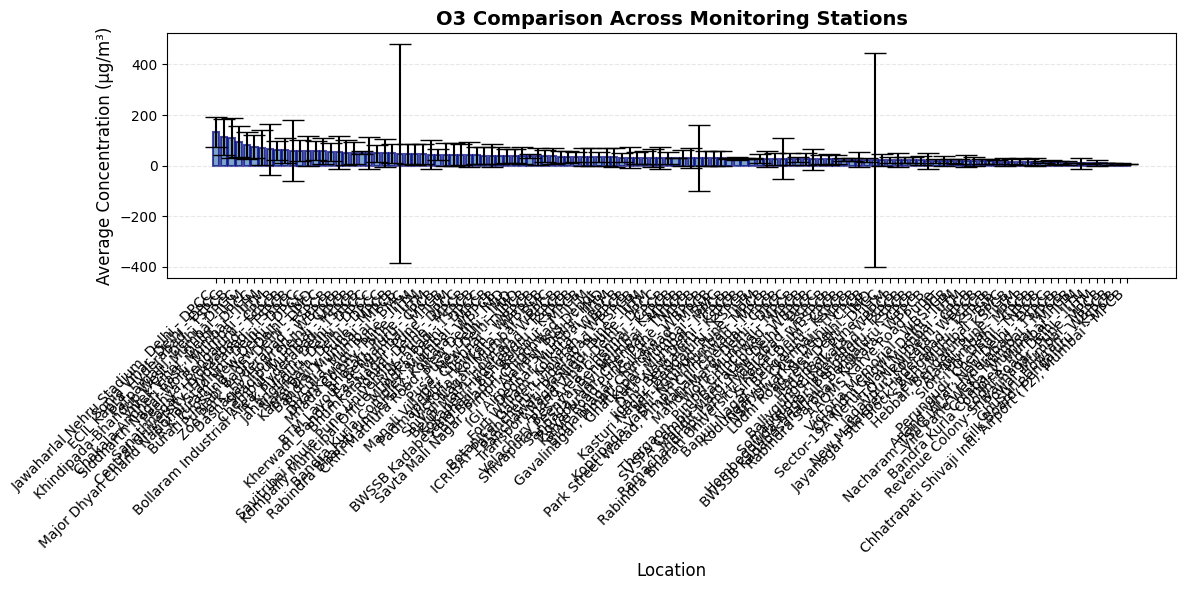


Numerical comparison for O3 across locations:

                                              Location       Mean    Std Dev  Count
               Jawaharlal Nehru Stadium, Delhi - DPCC 132.485714  59.479756     14
                            Sonia Vihar, Delhi - DPCC 113.835294  69.675417     17
                        ECIL Kapra, Hyderabad - TSPCB 108.556160  78.885855   1000
                             Patparganj, Delhi - DPCC  94.371429  61.165171     21
               Khindipada-Bhandup West, Mumbai - IITM  80.307000  52.069146   1000
                            Vivek Vihar, Delhi - DPCC  75.575000  46.496072     16
                  Chakala-Andheri East, Mumbai - IITM  71.810000  69.350396   1000
                 Siddharth Nagar-Worli, Mumbai - IITM  64.392000 100.190321   2000
                             Peenya, Bengaluru - CPCB  61.481300  37.148441   1000
                       Sanathnagar, Hyderabad - TSPCB  60.234510  50.268815   2000
                Central University, Hy

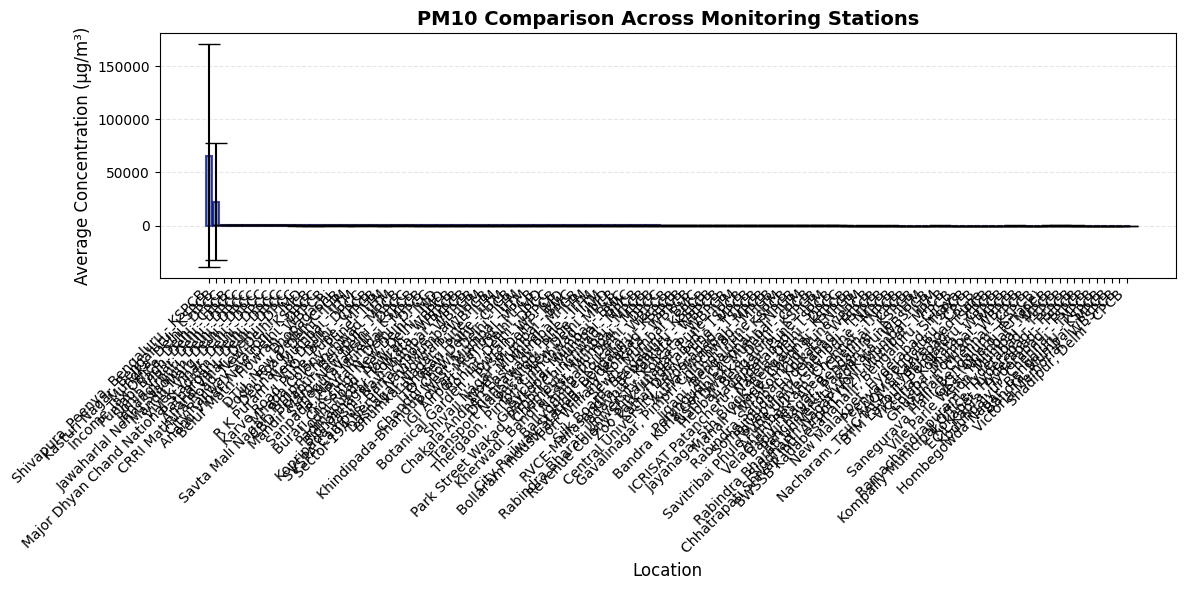


Numerical comparison for PM10 across locations:

                                              Location         Mean       Std Dev  Count
                  Shivapura_Peenya, Bengaluru - KSPCB 65857.973970 104413.456431   1000
                     Kasturi Nagar, Bengaluru - KSPCB 22483.316640  54865.328006   1000
                                 Mundka, Delhi - DPCC   568.160000    268.878322   1000
                      Income Tax Office, Delhi - CPCB   351.378000    205.503564   1000
                           Punjabi Bagh, Delhi - DPCC   323.527307    157.299790   1062
                            Sonia Vihar, Delhi - DPCC   279.582418    129.671985     91
                           Jahangirpuri, Delhi - DPCC   277.456790    118.939696     81
               Jawaharlal Nehru Stadium, Delhi - DPCC   276.338462    137.873275     65
                            Mandir Marg, Delhi - DPCC   276.300000    108.963375   1000
                            Vivek Vihar, Delhi - DPCC   239.772277   

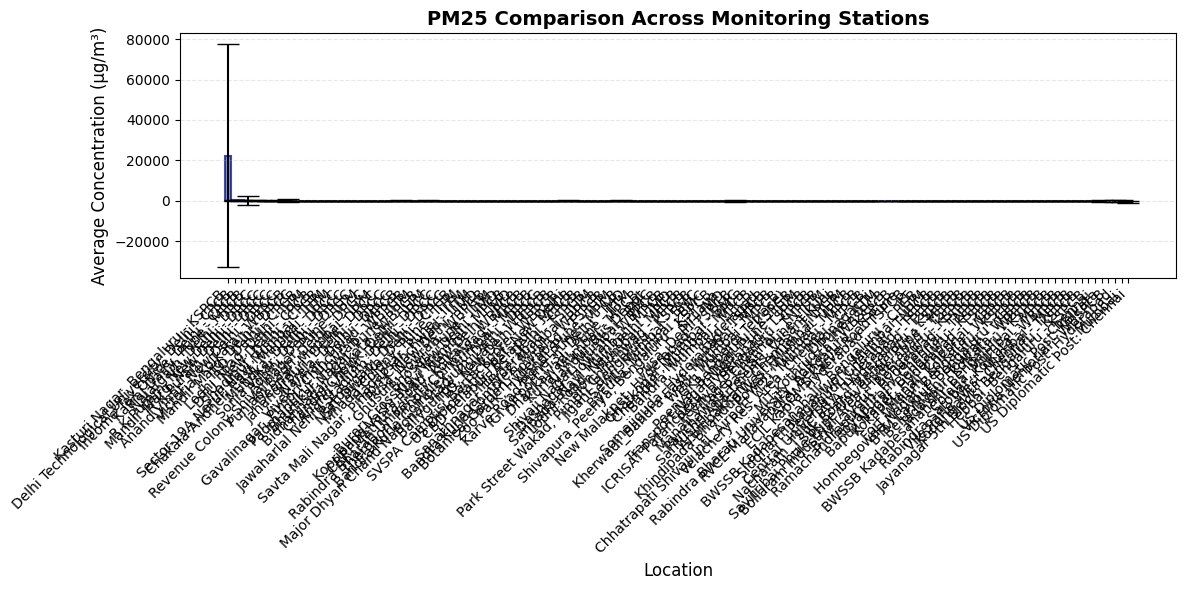


Numerical comparison for PM25 across locations:

                                              Location         Mean      Std Dev  Count
                     Kasturi Nagar, Bengaluru - KSPCB 22433.938600 54884.353373   1000
         Delhi Technological University, Delhi - CPCB   354.470800   173.099211   1000
                      Income Tax Office, Delhi - CPCB   274.482000   174.460070   1000
                            Katraj Dairy, Pune - MPCB   199.068970  2136.625481   1000
                              Najafgarh, Delhi - DPCC   181.997000    89.540675   1000
                          R K Puram, New Delhi - DPCC   172.666667    58.190485    177
                        Mandir Marg, New Delhi - DPCC   145.061350    46.775494    163
                              R K Puram, Delhi - DPCC   135.604000    68.680508   1000
                        Anand Vihar, New Delhi - DPCC   135.298000   115.525995   1000
                            Victoria, Kolkata - WBPCB   132.622200   803.142387

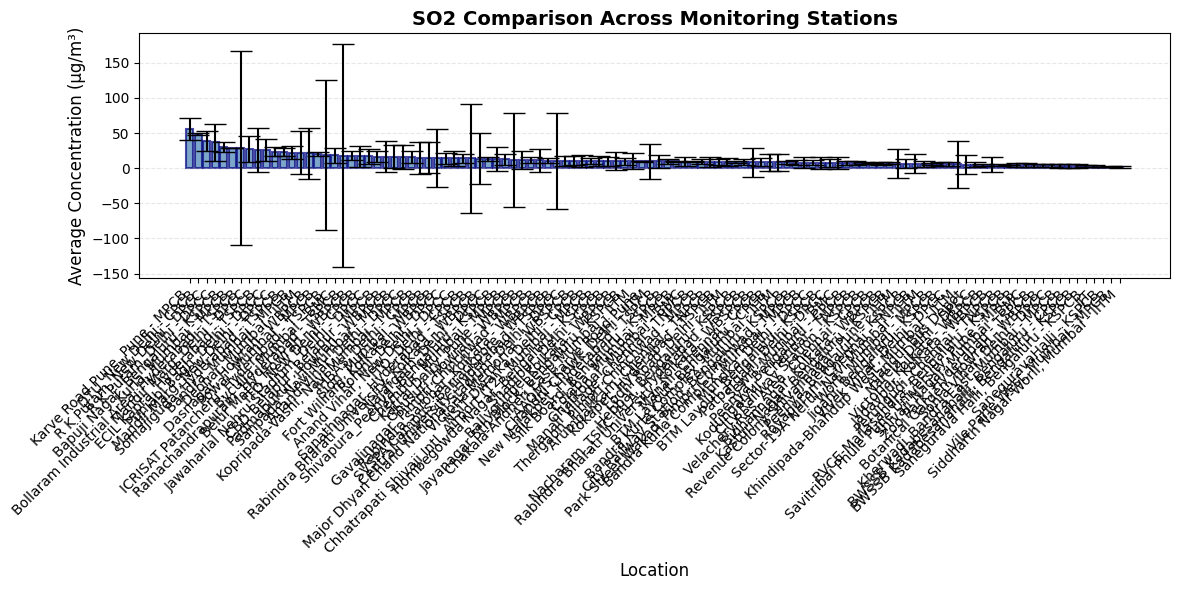


Numerical comparison for SO2 across locations:

                                              Location      Mean    Std Dev  Count
                         Karve Road Pune, Pune - MPCB 55.508280  15.670026   1000
                                DTU, New Delhi - CPCB 48.752440   1.632026   1000
                          R K Puram, New Delhi - DPCC 39.170909  14.205088    165
                              R K Puram, Delhi - DPCC 36.650300  25.724225   1000
                      Bapuji Nagar, Bengaluru - KSPCB 30.020200   7.152840   1000
                                 Kurla, Mumbai - MPCB 29.215370   0.126423   1000
          Bollaram Industrial Area, Hyderabad - TSPCB 28.512900 137.746845   1000
                            Mandir Marg, Delhi - DPCC 27.314800  18.849544   1000
                        ECIL Kapra, Hyderabad - TSPCB 26.037570  30.956103   1000
                           Punjabi Bagh, Delhi - DPCC 25.720246  15.205772   1057
                        Mandir Marg, New Delhi -

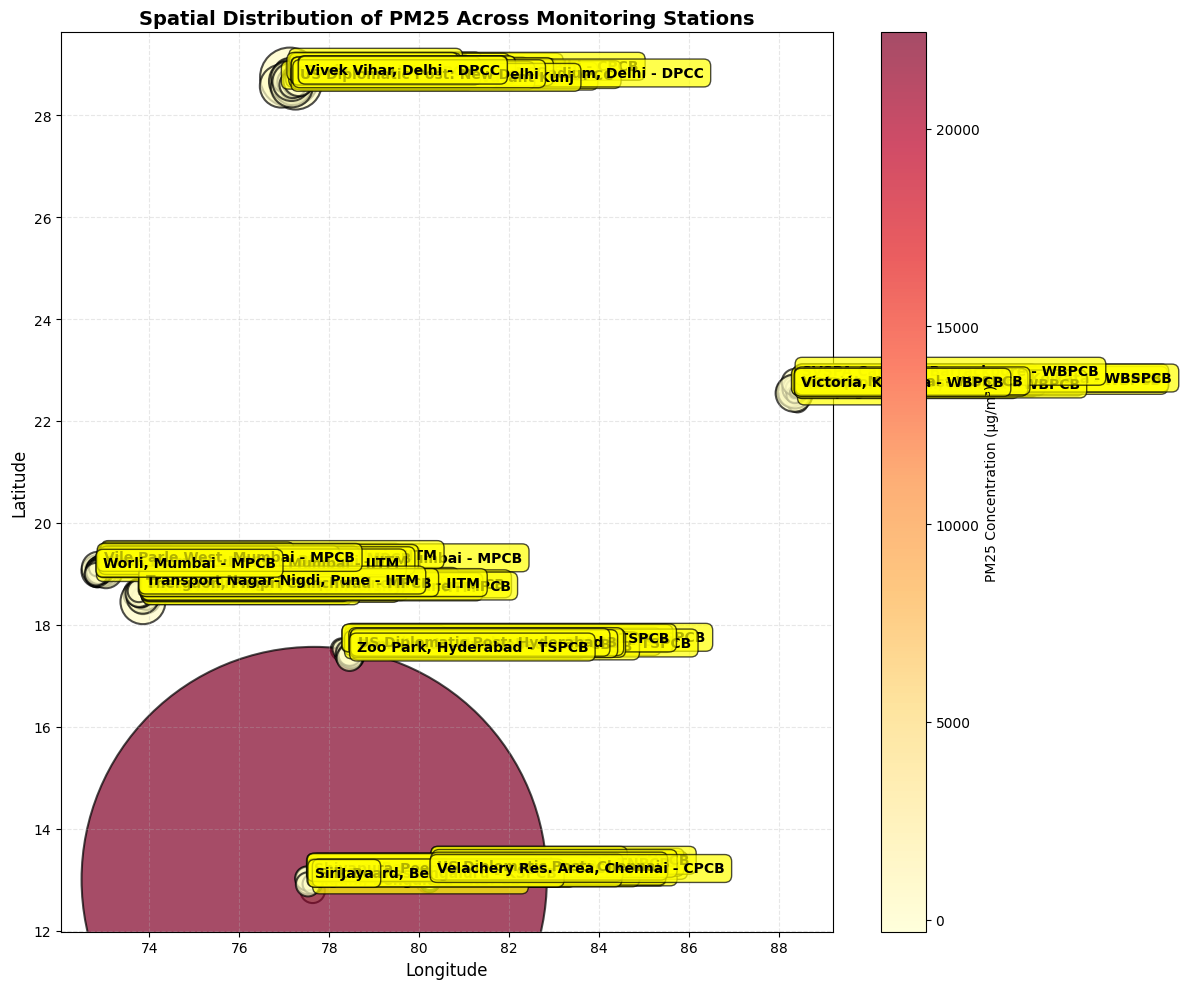


SUMMARY STATISTICS BY LOCATION (All Parameters Combined)

                                              Location       Mean    Std Dev         Min         Max  Count
                                AAQMS Karve Road Pune   469.0639   883.4891      0.5700   2920.0000   5000
                                  Alandi, Pune - IITM   179.2809   346.0529      0.0000   3350.0000   5000
                                    Alandur Bus Depot   633.1097  4564.4080      0.3200  49300.0000   4103
                            Anand Vihar, Delhi - DPCC   579.7888  3688.8744      0.0000 127000.0000  12000
                        Anand Vihar, New Delhi - DPCC    76.6250   100.2519      0.0000    764.0000   6000
                          Arumbakkam, Chennai - TNPCB    33.7922    33.6514      0.0000    211.0000   4000
                         BTM Layout, Bengaluru - CPCB    27.0577    29.0410     -8.7900    999.9900   6000
                        BTM Layout, Bengaluru - KSPCB    91.1698   746.6838      0.0

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the data
file_name = 'combined.csv'
print(f"Loading data from '{file_name}'...")

ddf = dd.read_csv(file_name, parse_dates=['datetimeUtc'], assume_missing=True)

print("\n--- Data Loaded ---")
print(f"Columns: {ddf.columns.tolist()}")

# Filter out null values
ddf_filtered = ddf[ddf['value'].isnull() == False]

# Convert to pandas for analysis
all_data = ddf_filtered.compute()

print(f"\nTotal records: {len(all_data)}")

# ============================================
# DATA CLEANING & PREPARATION
# ============================================

# Ensure value is numeric
all_data['value'] = pd.to_numeric(all_data['value'], errors='coerce')

# Remove rows with NaN in critical columns
all_data = all_data.dropna(subset=['value', 'parameter', 'location_name'])

print(f"Records after cleaning: {len(all_data)}")
print(f"\nLocations: {all_data['location_name'].unique()}")
print(f"Number of locations: {all_data['location_name'].nunique()}")
print(f"Parameters: {all_data['parameter'].unique()}")

# ============================================
# LOCATION COMPARISON ANALYSIS
# ============================================

if 'location_name' not in all_data.columns or all_data['location_name'].isnull().all():
    print("Missing location data for analysis")
elif all_data['location_name'].nunique() <= 1:
    print("Analysis requires multiple monitoring locations, but only one location found in the data.")
else:
    print("\nComparing air quality across different monitoring locations...")

    # Group by location and parameter
    location_data = all_data.groupby(['location_name', 'parameter'])['value'].agg(
        ['mean', 'std', 'count']
    ).reset_index()

    print(f"Location data prepared with {len(location_data)} groups")
    print("\nLocation Data Sample:")
    print(location_data.head(10))

    # ============================================
    # PLOT 1: Bar charts for each parameter
    # ============================================
    print("\n" + "="*70)
    print("Creating location comparison bar charts for each parameter...")
    print("="*70)

    parameters = sorted(all_data['parameter'].unique())

    for param in parameters:
        param_data = location_data[location_data['parameter'] == param].copy()

        if len(param_data) > 1:
            # Get unit
            unit_val = all_data[all_data['parameter'] == param]['unit'].iloc[0] \
                       if 'unit' in all_data.columns else ''

            # Sort by mean value for better visualization
            param_data = param_data.sort_values('mean', ascending=False)

            print(f"  Creating bar chart for {param}...")

            plt.figure(figsize=(12, 6))

            plt.bar(range(len(param_data)), param_data['mean'],
                   yerr=param_data['std'],
                   alpha=0.7, capsize=8, color='steelblue', edgecolor='navy', linewidth=1.5)

            plt.title(f"{param.upper()} Comparison Across Monitoring Stations",
                     fontsize=14, fontweight='bold')
            plt.xlabel('Location', fontsize=12)
            plt.ylabel(f'Average Concentration ({unit_val})', fontsize=12)
            plt.xticks(range(len(param_data)), param_data['location_name'],
                      rotation=45, ha='right')
            plt.grid(True, alpha=0.3, axis='y', linestyle='--')
            plt.tight_layout()
            plt.show()

            # Print numerical comparison
            print(f"\nNumerical comparison for {param.upper()} across locations:")
            comparison = param_data[['location_name', 'mean', 'std', 'count']].copy()
            comparison.columns = ['Location', 'Mean', 'Std Dev', 'Count']
            print("\n", comparison.to_string(index=False))

            # Find max and min
            max_loc = param_data.loc[param_data['mean'].idxmax(), 'location_name']
            max_val = param_data['mean'].max()
            min_loc = param_data.loc[param_data['mean'].idxmin(), 'location_name']
            min_val = param_data['mean'].min()

            print(f"\n  Highest: {max_loc} ({max_val:.4f} {unit_val})")
            print(f"  Lowest:  {min_loc} ({min_val:.4f} {unit_val})")

    # ============================================
    # PLOT 2: Spatial Distribution Map
    # ============================================
    if ('latitude' in all_data.columns and 'longitude' in all_data.columns and
        all_data['location_name'].nunique() >= 3):

        print("\n" + "="*70)
        print("Creating spatial distribution map...")
        print("="*70)

        try:
            # Get map parameter (prefer PM2.5 or use first parameter)
            map_param = 'pm25' if 'pm25' in parameters else parameters[0]

            # Get unique locations with their coordinates
            map_data = all_data[all_data['parameter'] == map_param].groupby(
                ['location_name', 'latitude', 'longitude']
            )['value'].mean().reset_index()

            # Get unit
            unit_val = all_data[all_data['parameter'] == map_param]['unit'].iloc[0] \
                       if 'unit' in all_data.columns else ''

            print(f"  Creating spatial map for {map_param}...")
            print(f"  Map contains {len(map_data)} locations")

            plt.figure(figsize=(12, 10))

            # Create scatter plot with color based on concentration
            scatter = plt.scatter(map_data['longitude'], map_data['latitude'],
                                c=map_data['value'], cmap='YlOrRd',
                                s=map_data['value'] * 5 + 50,
                                alpha=0.7, edgecolors='black', linewidth=1.5)

            # Annotate with location names
            for i, row in map_data.iterrows():
                plt.annotate(row['location_name'],
                           (row['longitude'], row['latitude']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=10, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

            plt.colorbar(scatter, label=f'{map_param.upper()} Concentration ({unit_val})')
            plt.title(f'Spatial Distribution of {map_param.upper()} Across Monitoring Stations',
                     fontsize=14, fontweight='bold')
            plt.xlabel('Longitude', fontsize=12)
            plt.ylabel('Latitude', fontsize=12)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"  Error creating spatial map: {str(e)}")
    else:
        print("\n  Spatial analysis requires latitude/longitude data and at least 3 locations.")

# ============================================
# SUMMARY STATISTICS BY LOCATION
# ============================================
print("\n" + "="*70)
print("SUMMARY STATISTICS BY LOCATION (All Parameters Combined)")
print("="*70)

location_summary = all_data.groupby('location_name')['value'].agg(
    ['mean', 'std', 'min', 'max', 'count']
).reset_index()
location_summary.columns = ['Location', 'Mean', 'Std Dev', 'Min', 'Max', 'Count']

print("\n", location_summary.round(4).to_string(index=False))

print("\n" + "="*70)
print("✓ Location comparison analysis complete!")
print("="*70)


**CCELL 17 DASK**

Loading data from 'combined.csv'...

--- Data Loaded ---
Columns: ['parameter', 'value', 'unit', 'datetimeUtc', 'location_id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_outlier', 'day_name']

Total records: 740101
Records after cleaning: 740101
Parameters: <ArrowStringArray>
['co', 'no2', 'pm25', 'so2', 'pm10', 'o3']
Length: 6, dtype: string
Number of unique parameters: 6

Analyzing correlations between air quality parameters...

Pivot table shape: (63794, 6)

Number of measurements for each parameter:
parameter
co      33686
no2     34969
o3      34442
pm10    39795
pm25    40283
so2     28204
dtype: int64

CORRELATION ANALYSIS

Correlation matrix:
parameter     co    no2     o3   pm10   pm25    so2
parameter                                          
co         1.000  0.162  0.012 -0.018  0.035  0.065
no2        0.162  1.000 -0.027 -0.018  0.179  0.131
o3         0.012 -0.027  1.000  0.001  0.003  0.036
pm10      -0.018 -0.018  0.001  1

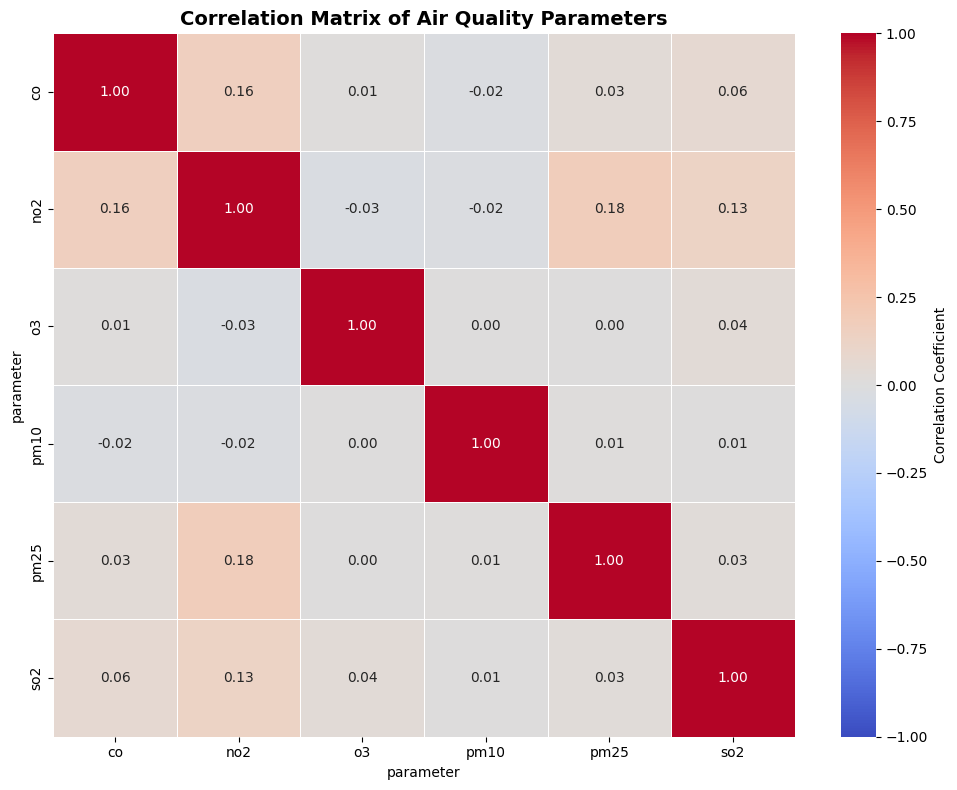


STRONGEST CORRELATIONS

Top 5 strongest correlations:

1. NO2 and PM25: 0.179
   Creating scatter plot...


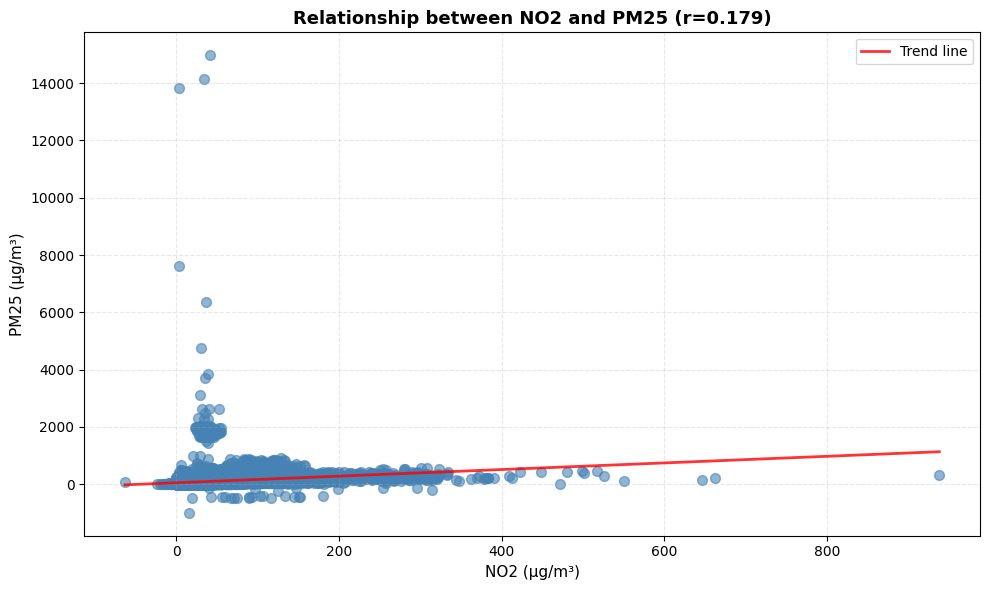

   Data points used: 26046

2. PM25 and NO2: 0.179
   Creating scatter plot...


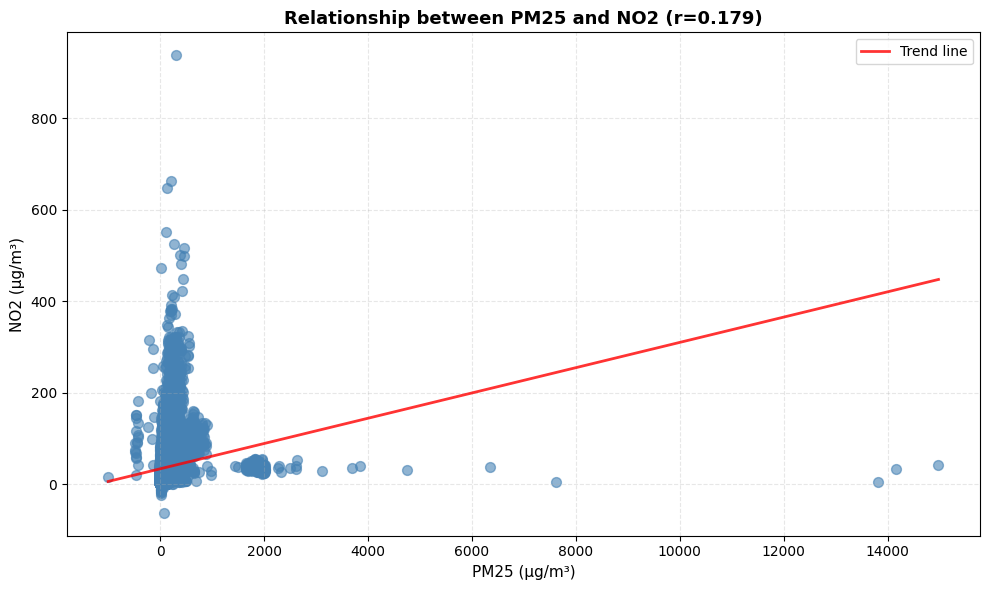

   Data points used: 26046

3. NO2 and CO: 0.162
   Creating scatter plot...


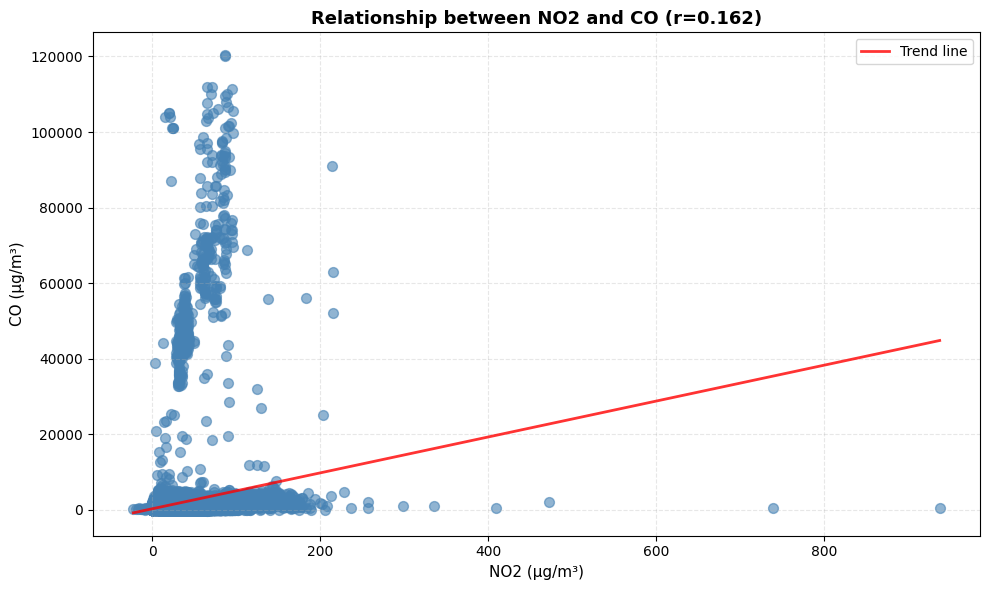

   Data points used: 28802

4. CO and NO2: 0.162

5. SO2 and NO2: 0.131

✓ Correlation analysis complete!


In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the data
file_name = 'combined.csv'
print(f"Loading data from '{file_name}'...")

ddf = dd.read_csv(file_name, parse_dates=['datetimeUtc'], assume_missing=True)

print("\n--- Data Loaded ---")
print(f"Columns: {ddf.columns.tolist()}")

# Filter out null values
ddf_filtered = ddf[ddf['value'].isnull() == False]

# Convert to pandas for analysis
all_data = ddf_filtered.compute()

print(f"\nTotal records: {len(all_data)}")

# ============================================
# DATA CLEANING & PREPARATION
# ============================================

# Ensure value is numeric
all_data['value'] = pd.to_numeric(all_data['value'], errors='coerce')

# Remove rows with NaN in critical columns
all_data = all_data.dropna(subset=['value', 'parameter', 'datetimeUtc'])

print(f"Records after cleaning: {len(all_data)}")
print(f"Parameters: {all_data['parameter'].unique()}")
print(f"Number of unique parameters: {all_data['parameter'].nunique()}")

# ============================================
# CORRELATION ANALYSIS
# ============================================

if 'parameter' not in all_data.columns or all_data['parameter'].isnull().all():
    print("Missing parameter data for analysis")
elif all_data['parameter'].nunique() <= 1:
    print("Analysis requires multiple air quality parameters, but only one parameter found.")
else:
    print("\nAnalyzing correlations between air quality parameters...")

    try:
        # Create pivot table with time index
        pivot_data = all_data.pivot_table(
            index='datetimeUtc',
            columns='parameter',
            values='value',
            aggfunc='mean'
        )

        print(f"\nPivot table shape: {pivot_data.shape}")
        print("\nNumber of measurements for each parameter:")
        param_counts = pivot_data.count()
        print(param_counts)

        # Calculate correlation matrix
        if pivot_data.dropna().shape[0] > 10:
            print("\n" + "="*70)
            print("CORRELATION ANALYSIS")
            print("="*70)

            # Correlation with minimum 10 overlapping observations
            corr_matrix = pivot_data.corr(min_periods=10)

            print("\nCorrelation matrix:")
            print(corr_matrix.round(3))

            # ============================================
            # PLOT 1: Correlation Heatmap
            # ============================================
            print("\nCreating correlation heatmap...")

            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                       linewidths=0.5, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
            plt.title('Correlation Matrix of Air Quality Parameters', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            # ============================================
            # Find Strongest Correlations
            # ============================================
            print("\n" + "="*70)
            print("STRONGEST CORRELATIONS")
            print("="*70)

            # Unstack and remove self-correlations
            corr_unstack = corr_matrix.unstack()
            corr_unstack = corr_unstack[corr_unstack < 1.0]
            strongest_corr = corr_unstack.abs().sort_values(ascending=False)

            if len(strongest_corr) > 0:
                print("\nTop 5 strongest correlations:")

                for i in range(min(5, len(strongest_corr))):
                    param1, param2 = strongest_corr.index[i]
                    corr_val = corr_matrix.loc[param1, param2]

                    print(f"\n{i+1}. {param1.upper()} and {param2.upper()}: {corr_val:.3f}")

                    # Create scatter plots for top 3 correlations
                    if i < 3:
                        print(f"   Creating scatter plot...")

                        plt.figure(figsize=(10, 6))

                        # Get data for both parameters
                        mask = ~(pivot_data[param1].isnull() | pivot_data[param2].isnull())

                        if mask.sum() > 2:
                            x = pivot_data.loc[mask, param1]
                            y = pivot_data.loc[mask, param2]

                            # Scatter plot
                            plt.scatter(x, y, alpha=0.6, s=50, color='steelblue')

                            # Fit polynomial trend line
                            z = np.polyfit(x, y, 1)
                            p = np.poly1d(z)
                            x_line = np.linspace(x.min(), x.max(), 100)
                            plt.plot(x_line, p(x_line), "r-", alpha=0.8, linewidth=2, label='Trend line')

                            # Get units
                            unit1 = all_data[all_data['parameter'] == param1]['unit'].iloc[0] \
                                   if 'unit' in all_data.columns else ''
                            unit2 = all_data[all_data['parameter'] == param2]['unit'].iloc[0] \
                                   if 'unit' in all_data.columns else ''

                            plt.title(f'Relationship between {param1.upper()} and {param2.upper()} (r={corr_val:.3f})',
                                     fontsize=13, fontweight='bold')
                            plt.xlabel(f'{param1.upper()} ({unit1})', fontsize=11)
                            plt.ylabel(f'{param2.upper()} ({unit2})', fontsize=11)
                            plt.grid(True, alpha=0.3, linestyle='--')
                            plt.legend(fontsize=10)
                            plt.tight_layout()
                            plt.show()

                            print(f"   Data points used: {mask.sum()}")
        else:
            print("\n" + "="*70)
            print("PAIRWISE CORRELATION ANALYSIS")
            print("="*70)
            print("\nAttempting pairwise correlations without requiring complete rows...")

            parameters = sorted(all_data['parameter'].unique())

            # Create all parameter pairs
            param_pairs = []
            for i in range(len(parameters)):
                for j in range(i + 1, len(parameters)):
                    param_pairs.append((parameters[i], parameters[j]))

            print(f"\nAnalyzing {len(param_pairs)} parameter pairs...")

            correlation_results = []

            for param1, param2 in param_pairs:
                # Extract data for each parameter
                data1 = all_data[all_data['parameter'] == param1].set_index('datetimeUtc')['value']
                data2 = all_data[all_data['parameter'] == param2].set_index('datetimeUtc')['value']

                # Combine and drop NaN
                pair_data = pd.concat([data1, data2], axis=1).dropna()
                pair_data.columns = [param1, param2]

                # Calculate correlation
                if len(pair_data) > 10:
                    corr = pair_data.corr().iloc[0, 1]
                    correlation_results.append({
                        'Parameter 1': param1.upper(),
                        'Parameter 2': param2.upper(),
                        'Correlation': corr,
                        'N': len(pair_data)
                    })

                    print(f"  {param1.upper()} vs {param2.upper()}: r={corr:.3f} (n={len(pair_data)})")

            # Display results
            if correlation_results:
                print("\n" + "="*70)
                print("CORRELATION RESULTS")
                print("="*70)

                results_df = pd.DataFrame(correlation_results)
                results_df = results_df.sort_values('Correlation', key=abs, ascending=False)
                print("\n", results_df.to_string(index=False))

    except Exception as e:
        print(f"\nError in correlation analysis: {str(e)}")
        import traceback
        traceback.print_exc()

print("\n" + "="*70)
print("✓ Correlation analysis complete!")
print("="*70)


**CELL 18 DASK**

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the data
file_name = 'combined.csv'
print(f"Loading data from '{file_name}'...")

ddf = dd.read_csv(file_name, parse_dates=['datetimeUtc'], assume_missing=True)

print("\n--- Data Loaded ---")
print(f"Columns: {ddf.columns.tolist()}")

# Filter out null values
ddf_filtered = ddf[ddf['value'].isnull() == False]

# Convert to pandas for analysis
all_data = ddf_filtered.compute()

print(f"\nTotal records: {len(all_data)}")

# ============================================
# DATA CLEANING & PREPARATION
# ============================================

# Ensure value is numeric
all_data['value'] = pd.to_numeric(all_data['value'], errors='coerce')

# Remove rows with NaN in critical columns
all_data = all_data.dropna(subset=['value', 'parameter'])

print(f"Records after cleaning: {len(all_data)}")
print(f"Parameters: {all_data['parameter'].unique()}")
print(f"Parameter counts: {all_data['parameter'].value_counts().to_dict()}")

# ============================================
# SELECT TARGET PARAMETER FOR MODELING
# ============================================

print("\n" + "="*70)
print("SELECTING TARGET PARAMETER FOR PREDICTIVE MODELING")
print("="*70)

target_param = None

# Prefer PM2.5 if available
if 'pm25' in all_data['parameter'].unique():
    target_param = 'pm25'
    print("\n✓ PM2.5 found - using as target parameter")
else:
    # Select parameter with most data
    param_counts = all_data['parameter'].value_counts()
    if not param_counts.empty and param_counts.iloc[0] >= 30:
        target_param = param_counts.index[0]
        print(f"\n✓ Using {target_param} as target (highest frequency: {param_counts.iloc[0]} records)")
    else:
        print("\nNo parameter has sufficient data for modeling (minimum 30 required)")

if target_param:
    print(f"\nTarget Parameter: {target_param.upper()}")

    # Filter data for target parameter
    model_data = all_data[all_data['parameter'] == target_param].copy()

    print(f"Records for {target_param}: {len(model_data)}")

    if len(model_data) < 30:
        print(f"\n✗ Insufficient data for {target_param} modeling (need at least 30 points)")
        target_param = None
    else:
        print(f"✓ Sufficient data available for modeling")

        # ============================================
        # FEATURE ENGINEERING
        # ============================================

        print("\n" + "="*70)
        print("FEATURE ENGINEERING FOR TIME SERIES PREDICTION")
        print("="*70)

        # Sort by datetime
        if 'datetimeUtc' in model_data.columns and not model_data['datetimeUtc'].isnull().all():
            model_data = model_data.sort_values('datetimeUtc').reset_index(drop=True)
            print("\nData sorted by datetime")
        else:
            print("\nWarning: No datetime column found, proceeding without time-based sorting")

        print("\nCreating lag features...")

        # Lag features (1, 2, 3 steps)
        if len(model_data) > 5:
            for i in range(1, 4):
                model_data[f'value_lag_{i}'] = model_data['value'].shift(i)
            print(f"  ✓ Created lag features (lag_1, lag_2, lag_3)")

        # Moving averages
        if len(model_data) > 7:
            model_data['value_ma_3'] = model_data['value'].rolling(window=3, min_periods=1).mean()
            model_data['value_ma_7'] = model_data['value'].rolling(window=7, min_periods=1).mean()
            print(f"  ✓ Created moving average features (ma_3, ma_7)")

        print("\nCreating cyclical features (sine/cosine encoding)...")

        # Month cyclical encoding (12 months)
        if 'month' in model_data.columns and not model_data['month'].isnull().all():
            model_data['month'] = pd.to_numeric(model_data['month'], errors='coerce')
            model_data['month_sin'] = np.sin(2 * np.pi * model_data['month'] / 12)
            model_data['month_cos'] = np.cos(2 * np.pi * model_data['month'] / 12)
            print(f"  ✓ Created month cyclical features (month_sin, month_cos)")

        # Day cyclical encoding (31 days)
        if 'day' in model_data.columns and not model_data['day'].isnull().all():
            model_data['day'] = pd.to_numeric(model_data['day'], errors='coerce')
            model_data['day_sin'] = np.sin(2 * np.pi * model_data['day'] / 31)
            model_data['day_cos'] = np.cos(2 * np.pi * model_data['day'] / 31)
            print(f"  ✓ Created day cyclical features (day_sin, day_cos)")

        # Hour cyclical encoding (24 hours)
        if 'hour' in model_data.columns and not model_data['hour'].isnull().all():
            model_data['hour'] = pd.to_numeric(model_data['hour'], errors='coerce')
            model_data['hour_sin'] = np.sin(2 * np.pi * model_data['hour'] / 24)
            model_data['hour_cos'] = np.cos(2 * np.pi * model_data['hour'] / 24)
            print(f"  ✓ Created hour cyclical features (hour_sin, hour_cos)")

        # Day of week cyclical encoding (7 days)
        if 'dayofweek' in model_data.columns and not model_data['dayofweek'].isnull().all():
            model_data['dayofweek'] = pd.to_numeric(model_data['dayofweek'], errors='coerce')
            model_data['weekday_sin'] = np.sin(2 * np.pi * model_data['dayofweek'] / 7)
            model_data['weekday_cos'] = np.cos(2 * np.pi * model_data['dayofweek'] / 7)
            print(f"  ✓ Created weekday cyclical features (weekday_sin, weekday_cos)")

        # ============================================
        # DATA CLEANING AFTER FEATURE ENGINEERING
        # ============================================

        print("\nCleaning data after feature engineering...")

        model_data_clean = model_data.dropna()

        print(f"Rows before cleaning: {len(model_data)}")
        print(f"Rows after cleaning: {len(model_data_clean)}")
        print(f"Rows removed: {len(model_data) - len(model_data_clean)}")

        if len(model_data_clean) < 30:
            print(f"\n✗ Insufficient data after feature engineering")
            print(f"   Only {len(model_data_clean)} complete rows (need at least 30)")
            target_param = None
        else:
            print(f"\n✓ Dataset ready for modeling!")

            # ============================================
            # SUMMARY STATISTICS
            # ============================================

            print("\n" + "="*70)
            print("MODELING DATA SUMMARY")
            print("="*70)

            print(f"\nTarget Parameter: {target_param.upper()}")
            print(f"Total rows: {len(model_data_clean)}")
            print(f"Total columns: {model_data_clean.shape[1]}")
            print(f"Total features: {model_data_clean.shape[1] - 1}")  # Excluding target

            # Feature list
            feature_cols = [col for col in model_data_clean.columns if col not in ['value', 'parameter', 'unit', 'datetimeUtc', 'location_id', 'location_name']]

            print(f"\nEngineered Features ({len(feature_cols)}):")
            for i, feat in enumerate(feature_cols, 1):
                print(f"  {i}. {feat}")

            # Data types
            print(f"\nData Types:")
            print(model_data_clean.dtypes)

            # Statistical summary
            print(f"\nStatistical Summary:")
            summary_cols = ['value'] + [f for f in feature_cols if 'lag' in f or 'ma' in f]
            print(model_data_clean[summary_cols].describe().round(4))

            # ============================================
            # SAMPLE DATA
            # ============================================

            print("\n" + "="*70)
            print("SAMPLE OF PREPARED MODELING DATA")
            print("="*70)

            sample_cols = ['datetimeUtc', 'value', 'value_lag_1', 'value_lag_2', 'value_ma_3', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
            sample_cols = [col for col in sample_cols if col in model_data_clean.columns]

            print("\n", model_data_clean[sample_cols].head(10).to_string())

            # ============================================
            # SAVE MODELING DATA
            # ============================================

            print("\n" + "="*70)
            print("SAVING MODELING DATA")
            print("="*70)

            # Save to CSV
            output_file = f'{target_param}_modeling_data.csv'
            model_data_clean.to_csv(output_file, index=False)
            print(f"\n✓ Modeling data saved to: {output_file}")

            # Store for later use
            modeling_data = model_data_clean

            print("\n✓ Data is ready for predictive modeling in the next cell!")
            print(f"  - Variable name: modeling_data")
            print(f"  - Shape: {modeling_data.shape}")
            print(f"  - Features: {len(feature_cols)} engineered features")
else:
    print("\n✗ No suitable target parameter found for modeling")

print("\n" + "="*70)
print("✓ Feature engineering complete!")
print("="*70)


Loading data from 'combined.csv'...

--- Data Loaded ---
Columns: ['parameter', 'value', 'unit', 'datetimeUtc', 'location_id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_outlier', 'day_name']

Total records: 740101
Records after cleaning: 740101
Parameters: <ArrowStringArray>
['co', 'no2', 'pm25', 'so2', 'pm10', 'o3']
Length: 6, dtype: string
Parameter counts: {'pm25': 135223, 'no2': 128454, 'co': 124617, 'pm10': 122117, 'o3': 120500, 'so2': 109190}

SELECTING TARGET PARAMETER FOR PREDICTIVE MODELING

✓ PM2.5 found - using as target parameter

Target Parameter: PM25
Records for pm25: 135223
✓ Sufficient data available for modeling

FEATURE ENGINEERING FOR TIME SERIES PREDICTION

Data sorted by datetime

Creating lag features...
  ✓ Created lag features (lag_1, lag_2, lag_3)
  ✓ Created moving average features (ma_3, ma_7)

Creating cyclical features (sine/cosine encoding)...
  ✓ Created month cyclical features (month_sin, month_cos)
  ✓ C

In [3]:
# 🧱 1️⃣ Install Java and Spark dependencies
!apt-get install openjdk-11-jdk -qq
!pip install pyspark -q

# ⚙️ 2️⃣ Set Java environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

# 🚀 3️⃣ Now safely create SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("OpenAQ_PM25_Prediction").getOrCreate()

print("✅ Spark session started successfully!")


Selecting previously unselected package java-common.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../00-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../01-libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../02-openjdk-11-jre-headless_11.0.28+6-1ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../03-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../04-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-

Original rows: 107410
Data shuffled successfully.
+-------------------+-----------+--------------------+---------+---------+----+-----+---+----+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------------+-------------+
|        datetimeutc|location_id|       location_name| latitude|longitude|year|month|day|hour|dayofweek|                  co|                 no2|                  o3|                pm10|                pm25|                 so2|is_weekend|            hour_sin|           hour_cos|pm25_category|
+-------------------+-----------+--------------------+---------+---------+----+-----+---+----+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------------+-------------+
|2025-02-25 04:30:00|      10485|Narela, Delhi - DPCC|28.82

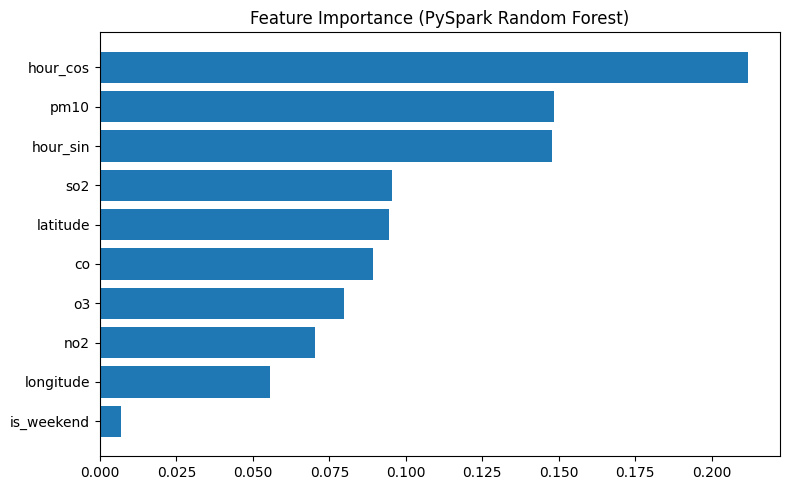

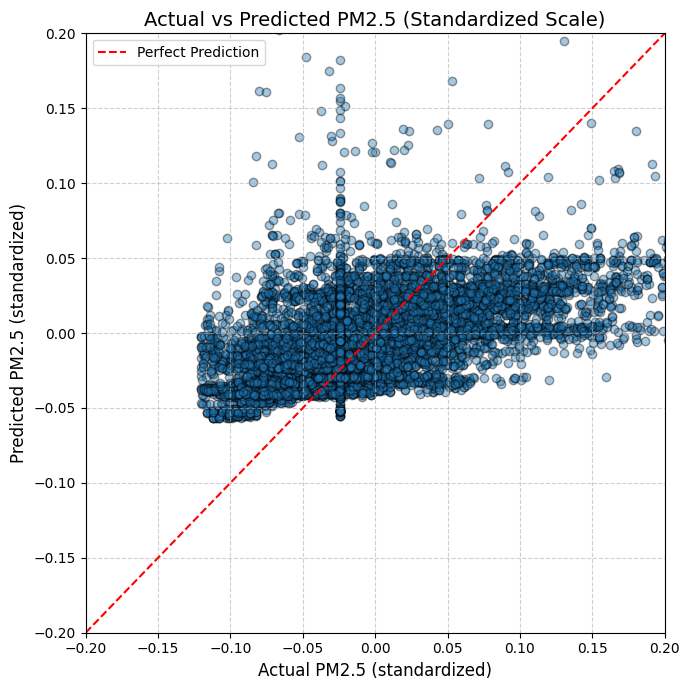

✅ PySpark pipeline complete.


In [5]:
# ==========================================
# 🚀 OpenAQ PM2.5 Prediction — PySpark Version
# ==========================================

# 🧱 1️⃣ Setup PySpark in Colab
!pip install pyspark -q

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("OpenAQ_PM25_Prediction").getOrCreate()

from pyspark.sql.functions import col, rand
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# 2️⃣ Load and Shuffle Dataset
# ==========================================
file_path = "/content/ml_ready_air_quality.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)
print("Original rows:", df.count())

# Shuffle using random column
df = df.orderBy(rand())
print("Data shuffled successfully.")
df.show(5)

# ==========================================
# 3️⃣ Feature Selection
# ==========================================
feature_cols = [
    'co', 'no2', 'o3', 'pm10', 'so2',
    'hour_sin', 'hour_cos',
    'is_weekend', 'latitude', 'longitude'
]
target_col = 'pm25'

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select(col("features"), col(target_col).alias("label"))

# ==========================================
# 4️⃣ Split Train/Test
# ==========================================
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print(f"Training samples: {train_data.count()}, Testing samples: {test_data.count()}")

# ==========================================
# 5️⃣ Train Random Forest Model
# ==========================================
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=200, seed=42)
model = rf.fit(train_data)

# ==========================================
# 6️⃣ Evaluate Model
# ==========================================
predictions = model.transform(test_data)

evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

# approximate regression accuracy
mean_label = test_data.selectExpr("avg(label)").collect()[0][0]
accuracy = 100 * (1 - (mae / mean_label)) if mean_label != 0 else None

print(f"R² Score : {r2:.4f}")
print(f"RMSE     : {rmse:.4f}")
print(f"MAE      : {mae:.4f}")
if accuracy:
    print(f"Approx. Accuracy: {accuracy:.2f}%")

# ==========================================
# 7️⃣ Feature Importance
# ==========================================
importances = model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(8,5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.title("Feature Importance (PySpark Random Forest)")
plt.tight_layout()
plt.show()

# ==========================================
# 8️⃣ Visualization — Actual vs Predicted
# ==========================================
pred_pd = predictions.select("label", "prediction").toPandas()

plt.figure(figsize=(7,7))
plt.scatter(pred_pd["label"], pred_pd["prediction"], alpha=0.4, edgecolors='k')
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'r--', label='Perfect Prediction')
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel("Actual PM2.5 (standardized)", fontsize=12)
plt.ylabel("Predicted PM2.5 (standardized)", fontsize=12)
plt.title("Actual vs Predicted PM2.5 (Standardized Scale)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ==========================================
# ✅ Done
# ==========================================
spark.stop()
print("✅ PySpark pipeline complete.")
